# NFL Fantasy Football Project

It's Monday night, I have just gotten off of a long day at work, and the anxiety has been building all day. I pick up my phone and open up the ESPN fantasy football app (where I have hosted my fantasy football league, affectionately dubbed "The League" as an homage to one of our favorite football themed sitcoms, for over ten years) and I click on my matchup. I'm down 15 points and I have one wide receiver left who is playing in the Monday night game. Can he get the 15 points I need to secure the win this week? Or will all my anticipation lead to dissapointment as I head to sleep and into the waiver wire section of the week? If you're a fantasy football fan, you know that this question almost always leads to dissapointment (although from a statistical standpoint that is liekly not true).

This is the situation I have found myself in many times over the years. As a fantasy football fanatic, I cannot get enough of the highs (and lows) the game has to offer. However, wouldn't those highs and lows be a bit higher if I could know with more certainty how my team would perform? What if I could improve upon the already fairly robust fantasy projection systems most major fantasy apps have? This is the quest of this project!

The goal is to create an app/dashboard with all the information I need to dominate my league. Projections, historical data, vizualizations, and potential sleepers will all be located in one, easy to use interface. If I'm feeling generous I may even share this useful tool with my league-mates!

## This Notebook - EDA and Feature Engineering
The point of this notebook is to introduce the data I'll be using for this project. I want to explore the data, visualize it, clean it, and engineer some features of interest! Data comes from the [NFL Data API](https://github.com/cooperdff/nfl_data_py/tree/main) which not only contains play-by-play data from every NFL game, but also compiles statistics and metrics from other popular NFL stat gathering sources (such as AWS).

In [1]:
import nfl_data_py as nfl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
from dotenv import load_dotenv
import os
import requests

load_dotenv()


sns.set_theme()
# 2015 is an arbitrary starting year, we could include more data in the future
year = [2015, 2017, 2016, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
export = False

## Messing Around

This is where we just try to explore the data and get new features, this is all formalized in the above section.

### Data Imports and Brief Exploration

Import all the data we will need from the nfl data api

In [2]:
# this code avoids a numpy error. nfl_data_py will have a new version soon to handle new python and numpy versions
_read_parquet = pd.read_parquet

def patched_read_parquet(*args, **kwargs):
    kwargs['engine'] = 'pyarrow'
    return _read_parquet(*args, **kwargs)

pd.read_parquet = patched_read_parquet

In [3]:
# this maps player ID's from accross multiple platforms. There is also associated player information like Name, College, etc.
id_map = nfl.import_ids()

# we want to have depth charts as depth is likely a good predictor of fantasy value. 1st string is utilized more than 3rd string
depth_charts = nfl.import_depth_charts(years=year)

# importing next gen stats data from AWS
ngs_receiving = nfl.import_ngs_data(stat_type="receiving", years=year).drop_duplicates()

# pro football reference stats
# there is no data prior to 2018 for PFR
pfr_receiving = nfl.import_weekly_pfr(s_type="rec", years=[y for y in year if y > 2017]).drop_duplicates()

# # weekly aggregate stats
weekly = nfl.import_weekly_data(years=year, downcast=True).drop_duplicates()
# I need to standardize the game ID and player ID's accross the dataframes
matchup_data = nfl.import_schedules(year)

# grab play-by-play data to synthesize some base stats. Adding in stats from other platforms after the fact.
pbp_data = nfl.import_pbp_data(years=year[:-1])

# importing rushing next gen stats data
ngs_rush = nfl.import_ngs_data(stat_type="rushing", years=year).drop_duplicates()

# rushing pro football reference stats
pfr_rush = nfl.import_weekly_pfr(s_type="rush", years=[y for y in year if y > 2017]).drop_duplicates()

# importing injuries
injuries = nfl.import_injuries(years=year)

Downcasting floats.
2015 done.
2017 done.
2016 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [4]:
# 2024 data has a bug
# grab play-by-play data to synthesize some base stats. Adding in stats from other platforms after the fact.
from warnings import simplefilter 
import numpy as np
simplefilter(action="ignore", category=pd.errors.PerformanceWarning) 
temp_2024_pbp = nfl.import_pbp_data(years=[2024], include_participation=False)

for c in [c for c in pbp_data.columns.tolist() if c not in temp_2024_pbp.columns.tolist()]:
    temp_2024_pbp[c] = np.nan

2024 done.
Downcasting floats.


In [5]:
pbp_data = pd.concat([pbp_data, temp_2024_pbp[pbp_data.columns.tolist()]], ignore_index = True)

C:\Users\cbrad\AppData\Local\Temp\ipykernel_14044\238819443.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pbp_data = pd.concat([pbp_data, temp_2024_pbp[pbp_data.columns.tolist()]], ignore_index = True)


In [8]:
pbp_data[(pbp_data['game_id'].str.contains('2017')) & (pbp_data['week'] < 2)].defteam.unique()

array([None, 'DET', 'ARI', 'CHI', 'ATL', 'BAL', 'CIN', 'SF', 'CAR', 'IND',
       'LA', 'HOU', 'JAX', 'KC', 'NE', 'LAC', 'DEN', 'MIN', 'NO', 'NYG',
       'DAL', 'NYJ', 'BUF', 'TEN', 'LV', 'PHI', 'WAS', 'PIT', 'CLE', 'GB',
       'SEA'], dtype=object)

In [11]:
pbp_data[(pbp_data['game_id'].str.contains('2017')) & ((pbp_data['home_team'] == 'MIA') | (pbp_data['away_team'] == 'MIA'))& (pbp_data['week'] < 2)]

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type


In [12]:
r_col_list = ["week", "position", "player_name", "player_id", "team", "status"]
rosters = pd.DataFrame(columns=r_col_list)
# this is due to a bug in the NFL data API. This function does not work when you pass it multiple years all at once
for yr in year:
    t_roster = nfl.import_weekly_rosters(years=[yr])[r_col_list]
    t_roster["season"] = yr
    if yr < 2021:
        t_roster = t_roster[t_roster.week <= 17]
    else:
        t_roster = t_roster[t_roster.week <= 18]
    rosters = pd.concat([rosters, t_roster], ignore_index=True)

In [16]:
rosters[(rosters['team'] == 'BLT') & (rosters['position'] == 'QB') & (rosters['week'] == 'QB')]

,week,position,player_name,player_id,team,status,season
749,5,QB,Matt Schaub,00-0022787,BLT,ACT,2015.0
750,3,QB,Matt Schaub,00-0022787,BLT,ACT,2015.0
751,12,QB,Matt Schaub,00-0022787,BLT,ACT,2015.0
752,10,QB,Matt Schaub,00-0022787,BLT,ACT,2015.0
753,4,QB,Matt Schaub,00-0022787,BLT,ACT,2015.0
754,17,QB,Matt Schaub,00-0022787,BLT,ACT,2015.0
755,11,QB,Matt Schaub,00-0022787,BLT,ACT,2015.0
756,13,QB,Matt Schaub,00-0022787,BLT,ACT,2015.0
757,9,QB,Matt Schaub,00-0022787,BLT,ACT,2015.0
758,7,QB,Matt Schaub,00-0022787,BLT,ACT,2015.0


### Print Column Names

In [8]:
# What data appears in each dataset?
print(
    textwrap.fill(
        f"We have the following columns in the IDs dataset: {*id_map.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the IDs dataset: ('mfl_id', 'sportradar_id', 'fantasypros_id', 'gsis_id', 'pff_id',
 'sleeper_id', 'nfl_id', 'espn_id', 'yahoo_id', 'fleaflicker_id', 'cbs_id', 'pfr_id', 'cfbref_id', 'rotowire_id',
 'rotoworld_id', 'ktc_id', 'stats_id', 'stats_global_id', 'fantasy_data_id', 'swish_id', 'name', 'merge_name',
 'position', 'team', 'birthdate', 'age', 'draft_year', 'draft_round', 'draft_pick', 'draft_ovr', 'twitter_username',
 'height', 'weight', 'college', 'db_season')


In [9]:
print(
    textwrap.fill(
        f"We have the following columns in the depth charts dataset: {*depth_charts.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the depth charts dataset: ('season', 'club_code', 'week', 'game_type', 'depth_team',
 'last_name', 'first_name', 'football_name', 'formation', 'gsis_id', 'jersey_number', 'position', 'elias_id',
 'depth_position', 'full_name')


In [10]:
print(
    textwrap.fill(
        f"We have the following columns in the Next Gen Stats dataset: {*ngs_receiving.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the Next Gen Stats dataset: ('season', 'season_type', 'week', 'player_display_name',
 'player_position', 'team_abbr', 'avg_cushion', 'avg_separation', 'avg_intended_air_yards',
 'percent_share_of_intended_air_yards', 'receptions', 'targets', 'catch_percentage', 'yards', 'rec_touchdowns',
 'avg_yac', 'avg_expected_yac', 'avg_yac_above_expectation', 'player_gsis_id', 'player_first_name', 'player_last_name',
 'player_jersey_number', 'player_short_name')


In [11]:
print(
    textwrap.fill(
        f"We have the following columns in the Pro Football Reference dataset: {*pfr_receiving.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the Pro Football Reference dataset: ('game_id', 'pfr_game_id', 'season', 'week',
 'game_type', 'team', 'opponent', 'pfr_player_name', 'pfr_player_id', 'rushing_broken_tackles',
 'receiving_broken_tackles', 'passing_drops', 'passing_drop_pct', 'receiving_drop', 'receiving_drop_pct',
 'receiving_int', 'receiving_rat')


In [12]:
print(
    textwrap.fill(
        f"We have the following columns in the weekly stats dataset: {*weekly.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the weekly stats dataset: ('player_id', 'player_name', 'player_display_name',
 'position', 'position_group', 'headshot_url', 'recent_team', 'season', 'week', 'season_type', 'opponent_team',
 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
 'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets',
 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'racr',
 'target_share', 'air_yards_share', 'wopr', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr')


In [13]:
print(
    textwrap.fill(
        f"We have the following columns in the play-by-play dataset: {*pbp_data.columns.tolist(),}",
        width=130,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the play-by-play dataset: ('play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date',
 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp',
 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle',
 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch',
 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result',
 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id',
 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score',
 'defteam_score', 'score_differentia

In [14]:
print(
    textwrap.fill(
        f"We have the following columns in the Next Gen Stats (rushing) dataset: {*ngs_rush.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the Next Gen Stats (rushing) dataset: ('season', 'season_type', 'week',
 'player_display_name', 'player_position', 'team_abbr', 'efficiency', 'percent_attempts_gte_eight_defenders',
 'avg_time_to_los', 'rush_attempts', 'rush_yards', 'avg_rush_yards', 'rush_touchdowns', 'player_gsis_id',
 'player_first_name', 'player_last_name', 'player_jersey_number', 'player_short_name', 'expected_rush_yards',
 'rush_yards_over_expected', 'rush_yards_over_expected_per_att', 'rush_pct_over_expected')


In [15]:
print(
    textwrap.fill(
        f"We have the following columns in the Pro Football Reference (rushing) dataset: {*pfr_rush.columns.tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

We have the following columns in the Pro Football Reference (rushing) dataset: ('game_id', 'pfr_game_id', 'season',
 'week', 'game_type', 'team', 'opponent', 'pfr_player_name', 'pfr_player_id', 'carries', 'rushing_yards_before_contact',
 'rushing_yards_before_contact_avg', 'rushing_yards_after_contact', 'rushing_yards_after_contact_avg',
 'rushing_broken_tackles', 'receiving_broken_tackles')


In [16]:
# let's check out some of the data issues I noticed
# there are some non-stadard team abbreviations in this dataset such as GBP and SDC.
print(
    textwrap.fill(
        f"Team abbreviations in id map dataset: {*id_map.team.unique().tolist(),}",
        width=120,
        initial_indent="",
        subsequent_indent=" ",
    )
)

Team abbreviations in id map dataset: ('CHI', 'NEP', 'WAS', 'DEN', 'ATL', 'MIN', 'NOS', 'FA', 'NYJ', 'LAR', 'ARI',
 'CAR', 'TBB', 'PHI', 'BUF', 'GBP', 'TEN', 'SEA', 'MIA', 'KCC', 'LVR', 'NYG', 'JAC', 'BAL', 'SFO', 'LAC', 'CLE', 'IND',
 'PIT', 'DET', 'CIN', 'HOU', 'DAL', 'OAK', 'STL', 'SDC', 'RAM', 'FA*')


In [17]:
# looks like there are no receiving stats for running backs in the Next Gen Stats dataset
# we'll have to synthesize these stats using play-by-play data
ngs_receiving.player_position.unique()

array(['WR', 'TE'], dtype=object)

### Data Cleaning

Let's clean up our datasets for analysis. We want to be sure that all the data we just imported is ready for aggregation and manipulation.

**A Note on Tyler Conklin and Ryan Izzo**

there is an issue with these two players. their gsis_id's are swapped in the play by play data. 

In [17]:
# here are these two players in the id_map
id_map[id_map["gsis_id"].isin(["00-0034439", "00-0034270"])][["gsis_id", "name"]]

,gsis_id,name
2374,00-0034270,Tyler Conklin
2541,00-0034439,Ryan Izzo


In [18]:
# you can see they are labeled oppositely in the PBP data
print(
    pbp_data[pbp_data["receiver_player_id"] == "00-0034439"]["receiver_player_name"]
    .unique()
    .tolist()
)
print(
    pbp_data[pbp_data["receiver_player_id"] == "00-0034439"]["posteam"]
    .unique()
    .tolist()
)

['R.Izzo']
['NE']


In [19]:
print(
    pbp_data[pbp_data["receiver_player_id"] == "00-0034270"]["receiver_player_name"]
    .unique()
    .tolist()
)
print(
    pbp_data[pbp_data["receiver_player_id"] == "00-0034270"]["posteam"]
    .unique()
    .tolist()
)

['T.Conklin']
['MIN', 'NYJ']


In [20]:
# fixing Conklin/Izzo issue
id_map["gsis_id"] = id_map["gsis_id"].replace(
    {"00-0034439": "00-0034270", "00-0034270": "00-0034439"}
)


This data is compiled from many different sources; thus, names, id's, codes, etc. can vary from platform to platform. Let's make sure that team ID's all look the same.

> Note: The Raiders, Chargers, and Rams have all moved since 2015. So their club codes will be a mixture of the codes from the two cities. For contistencies sake we will map all of them to their current club code. 

In [21]:
# we also need to map non-conventional city abbreviations for consistency
common_club_code_map =     {
        "LVR": "LV",
        "KCC": "KC",
        "NOS": "NO",
        "TBB": "TB",
        "SFO": "SF",
        "NEP": "NE",
        "GBP": "GB",
        "JAC": "JAX",
        "OAK":"LV",
        "STL":"LAR",
        "SL":"LAR",
        "SD":"LAC",
        "SDC":"LAC",
        "RAM":"LAR",
        "LA":"LAR",
        "BLT":"BAL",
        "HST":"HOU",
        "CLV":"CLE",
        "ARZ":"ARI"
    }
id_map["team"] = id_map["team"].replace(common_club_code_map)
depth_charts["club_code"] = depth_charts["club_code"].replace(common_club_code_map)
ngs_receiving["team_abbr"] = ngs_receiving["team_abbr"].replace(common_club_code_map)
pfr_receiving["team"] = pfr_receiving["team"].replace(common_club_code_map)
weekly["recent_team"] = weekly["recent_team"].replace(common_club_code_map)
weekly["opponent_team"] = weekly["opponent_team"].replace(common_club_code_map)
matchup_data["away_team"] = matchup_data["away_team"].replace(common_club_code_map)
matchup_data["home_team"] = matchup_data["home_team"].replace(common_club_code_map)
ngs_rush["team_abbr"] = ngs_rush["team_abbr"].replace(common_club_code_map)
pfr_rush["team"] = pfr_rush["team"].replace(common_club_code_map)
injuries['team'] = injuries['team'].replace(common_club_code_map)
rosters['team'] = rosters['team'].replace(common_club_code_map)

# team pops up in many columns in the pbp_data. not all in the below list are team name columns
# but for those that aren't, the replace just won't do anything. 
for col in [x for x in pbp_data.columns if 'team' in x]:
    pbp_data[col] = pbp_data[col].replace(common_club_code_map)

since we are going to use the game_id as a primary key, we want to add it to the datasets that do not have it

In [22]:
# here we grab unique game id's and home/away teams for each game in the season
game_id_map = pd.concat(
    [
        matchup_data[["game_id", "home_team", "week", "season"]].rename(
            {"home_team": "team_abbr"}, axis=1
        ),
        matchup_data[["game_id", "away_team", "week", "season"]].rename(
            {"away_team": "team_abbr"}, axis=1
        ),
    ],
    ignore_index=False,
)

# merges the AWS data with the game id data from above
ngs_receiving = ngs_receiving.merge(
    game_id_map,
    left_on=["week", "team_abbr", "season"],
    right_on=["week", "team_abbr", "season"],
).rename({"player_gsis_id": "player_id"}, axis=1)

# merges the PFR data with the game id data from above
pfr_receiving = pfr_receiving.merge(
    id_map[["pfr_id", "gsis_id"]], left_on=["pfr_player_id"], right_on=["pfr_id"]
).rename({"gsis_id": "player_id"}, axis=1)

# NOTE: The weekly data does not have the opponent team info for 2022. Thus we would need different logic to grab the game_id.
# We actually end up creating all the stats from this dataset by hand so there is no need.

# merges the depth chart data with the game id data from above
depth_charts = depth_charts.merge(
    game_id_map,
    left_on=["week", "club_code", "season"],
    right_on=["week", "team_abbr", "season"],
)

In [23]:
# columns renames
depth_charts = depth_charts.rename({"club_code": "team"}, axis=1)

# cleaning up depth charts
depth_charts_og = depth_charts.copy()
depth_charts = depth_charts[depth_charts['formation'] == 'Offense'].copy()
depth_charts['depth_position'] = depth_charts.apply(lambda x: x['position'] if x['depth_position'].strip() == '' else x['depth_position'], axis = 1)

Now we are going to fix a few more issues.

1. one-hot encode the two point conversion variable so we can use it to calculate points and eventually train on.
2. remove all NFL playoff games, we only want to train on the regular season since that is what applies to fantasy.
3. Fill null values with 0's  where applicable.
4. split up the list of players on a play into a list instead of a string.
5. restrict our main data (`pbp_data`) to only columns we are concerned with. This will make it easier to look at. 

In [24]:
# since we are going to aggregate the play-by-play data to game-by-game data, we want to fix some features so we can count easier
d = {}
# this just makes a countable two point conversion field. One-hot encoding if you will
d["is_two_point_conversion"] = pbp_data["two_point_conv_result"].apply(
    lambda x: 1 if x == "success" else 0
)
pbp_data = pd.concat([pbp_data, pd.DataFrame(d)], axis=1)



In [25]:
# we're only going to consider the regular season
# NOTE: In 2021, there was an extra regular season game added
t1 = pbp_data[
    (pbp_data.week <= 18)
    & (
        (pbp_data["game_id"].str.contains("2021"))
        | (pbp_data["game_id"].str.contains("2022"))
        | (pbp_data["game_id"].str.contains("2023"))
        | (pbp_data["game_id"].str.contains("2024"))
    )
].copy()
t2 = pbp_data[
    (pbp_data.week <= 17)
    & (
        (pbp_data["game_id"].str.contains("2020"))
        | (pbp_data["game_id"].str.contains("2019"))
        | (pbp_data["game_id"].str.contains("2018"))
        | (pbp_data["game_id"].str.contains("2017"))
        | (pbp_data["game_id"].str.contains("2016"))
        | (pbp_data["game_id"].str.contains("2015"))
    )
].copy()
pbp_data = pd.concat([t1, t2], ignore_index=True)


In [26]:

# just make sure that plays that don't result in a touchdown have data here. Another one-hot (ish)
pbp_data["touchdown"] = pbp_data["touchdown"].fillna(0)
pbp_data["interception"] = pbp_data["interception"].fillna(0)
pbp_data["fumble_lost"] = pbp_data["fumble_lost"].fillna(0)
pbp_data["passing_yards"] = pbp_data["passing_yards"].fillna(0)
pbp_data["pass_touchdown"] = pbp_data["pass_touchdown"].fillna(0)
pbp_data["rushing_yards"] = pbp_data["rushing_yards"].fillna(0)
pbp_data["rush_touchdown"] = pbp_data["rush_touchdown"].fillna(0)
pbp_data["receiving_yards"] = pbp_data["receiving_yards"].fillna(0)


In [27]:
# this creates a list of offensive players rather than a string. This helps later when we look at snaps played by each player
# NOTE: Some of these are missing.
pbp_data["offense_players"] = pbp_data["offense_players"].apply(
    lambda x: x.split(";") if type(x) == str else x
)

In [28]:
# we are also going to restrict to data that we need in the pbp_data, this will make it easier to look at
rel_cols_pbp = [
    "play_id",
    "game_id",
    "home_team",
    "away_team",
    "week",
    "posteam",
    "defteam",
    "yardline_100",
    "game_date",
    "game_seconds_remaining",
    "qtr",
    "down",
    "time",
    "desc",
    "play_type",
    "yards_gained",
    "air_yards",
    "yards_after_catch",
    "score_differential",
    "epa",
    "incomplete_pass",
    "interception",
    "penalty",
    "rush_attempt",
    "pass_attempt",
    "touchdown",
    "pass_touchdown",
    "rush_touchdown",
    "two_point_attempt",
    "fumble",
    "fumbled_1_team",
    "fumbled_1_player_id",
    "fumbled_1_player_name",
    "fumbled_2_player_id",
    "fumbled_2_player_name",
    "fumbled_2_team",
    "fumble_lost",
    "complete_pass",
    "passer_player_id",
    "passer_player_name",
    "passing_yards",
    "receiver_player_id",
    "receiver_player_name",
    "receiving_yards",
    "rusher_player_id",
    "rusher_player_name",
    "rushing_yards",
    "fumbled_1_player_id",
    "fumbled_2_player_id",
    "penalty_player_id",
    "penalty_yards",
    "replay_or_challenge",
    "replay_or_challenge_result",
    "penalty_type",
    "offense_players",
    "players_on_play",
    "timeout",
    "is_two_point_conversion",
    "first_down",
]

pbp_data = pbp_data[rel_cols_pbp].copy()

### Visualize missing info.
Now let's look at the missing information for the play-by-play data.

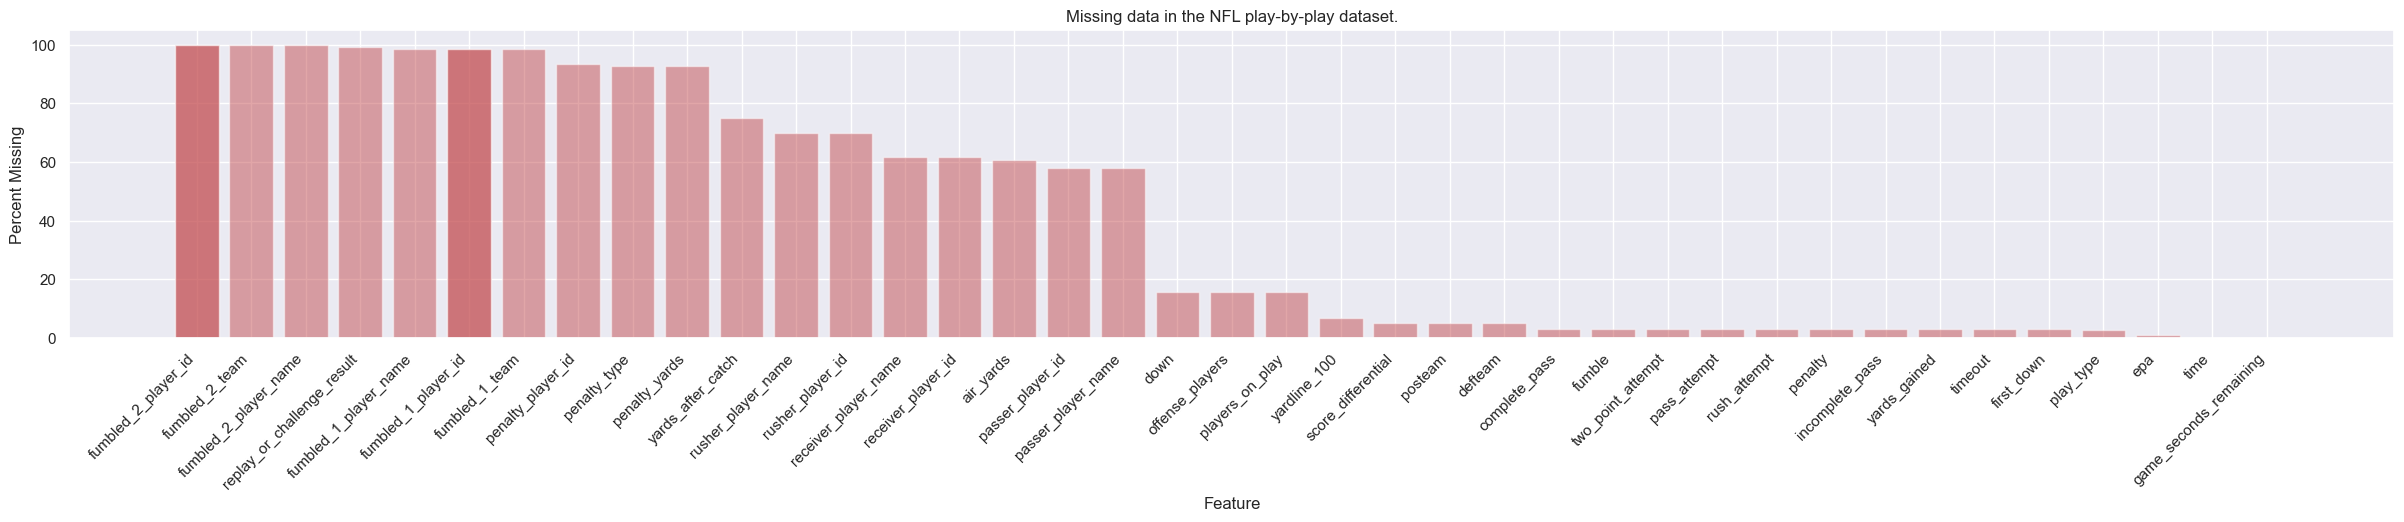

In [30]:
# do we have any missing data?
fig, ax = plt.subplots(figsize=(30, 4))

nan_feats = 100 * pbp_data.isna().sum() / len(pbp_data)
nan_feats_sorted = nan_feats[nan_feats > 0].sort_values(ascending=False)

ax.bar(nan_feats_sorted.index, nan_feats_sorted.values, color="r", alpha=0.5)

ax.set_title("Missing data in the NFL play-by-play dataset.")
ax.set_xlabel("Feature")
ax.set_ylabel("Percent Missing")

# fix tick labels
_ = ax.set_xticks(ax.get_xticks())
_ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha="right")

# # Make some labels.
# rects = ax.patches
# labels = [f"{perc:.2f}%" for perc in nan_feats_sorted.values]

# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(
#         rect.get_x() + rect.get_width() / 2, height + 2, label, ha="center", va="bottom", fontsize='x-small', rotation=90
#     )

# plt.show()

### Issues with `"offense_players"`

We will be wanting to know what players are available on which plays, in order to compute snap percentages, target percentages, targets/snap ratios, etc. There is a field that stores the `"gsis_id"` for each player on offense for each play: `"offense_players"`. Is that field filled out for each play? Let's investigate. 

In [31]:
temp_filter = pbp_data[
    (~pbp_data["play_type"].isin(["kickoff", "extra_point", "field_goal", "punt"]))
    & (~pbp_data["desc"].str.contains("Punt formation"))
    & (~pbp_data["desc"].str.contains(" punts "))
    & (~pbp_data["desc"].str.contains("Kick formation"))
]
print(
    f"""Of the {len(temp_filter):,} relevant plays (relevance to recieving is 
any non-kicking play), {temp_filter.offense_players.isna().sum():,} ({100*temp_filter.offense_players.isna().sum()/len(temp_filter):.1f}%) are missing personnel information."""
)

Of the 361,256 relevant plays (relevance to recieving is 
any non-kicking play), 56,684 (15.7%) are missing personnel information.


In [32]:
# this could affect our snap counts. What do these plays look like?
# how many are timeouts?
num_missing_pers = temp_filter.offense_players.isna().sum()
num_to = temp_filter[
    (temp_filter.offense_players.isna()) & (temp_filter["timeout"] == 1)
]["timeout"].sum()
print(
    f"Of the temp_filter {num_missing_pers:,} plays missing personnel info {num_to:,} are timeouts."
)
remain = num_missing_pers - num_to
# FIXME: you can be more robust here
num_time_marker = len(
    temp_filter[
        (temp_filter.offense_players.isna())
        & (temp_filter["timeout"] != 1)
        & (
            temp_filter["desc"].isin(
                [
                    "GAME",
                    "END GAME",
                    "END QUARTER 1",
                    "END QUARTER 2",
                    "END QUARTER 3",
                    "END QUARTER 4",
                ]
            )
        )
    ]
)

print(
    f"Of the remaining {remain:,} plays, {num_time_marker:,} are entries that denote the beginning/end of the game or a quarter. No plays occur on these entries."
)

Of the temp_filter 56,684 plays missing personnel info 2,889.0 are timeouts.
Of the remaining 53,795.0 plays, 1,911 are entries that denote the beginning/end of the game or a quarter. No plays occur on these entries.


In [33]:
# looks like our snap count info may be off. There are some plays without any personnel info
temp_filter[
    (temp_filter.offense_players.isna())
    & (temp_filter["timeout"] != 1)
    & (
        ~temp_filter["desc"].isin(
            [
                "GAME",
                "END GAME",
                "END QUARTER 1",
                "END QUARTER 2",
                "END QUARTER 3",
                "END QUARTER 4",
            ]
        )
    )
].sample(5)[["desc", "down", "offense_players", "timeout", "players_on_play"]]

,desc,down,offense_players,timeout,players_on_play
163946,(1:35) (Shotgun) 15-R.Mallett sacked at TB 46 ...,1.0,NaN,0.0,NaN
142779,(6:23) (Shotgun) 4-D.Prescott pass short left ...,2.0,NaN,0.0,NaN
165755,(11:35) (Shotgun) 5-B.Bortles pass incomplete ...,2.0,NaN,0.0,NaN
171036,(14:53) 16-D.Robinson right end to JAX 25 for ...,1.0,NaN,0.0,NaN
178277,(6:54) (Shotgun) 14-R.Fitzpatrick sacked at NY...,3.0,NaN,0.0,NaN


In [34]:
# TODO: justify need to engineer features

### Fumble Lost
Note that the fumble_lost variable only denotes if a fumble was lost on the play, not if the player in consideration (receiver, rusher, QB, etc.) fumbled the ball. Thus, a determination of which player lost the fumble is important for counting the number of fumbles committed by a player.

In [29]:
# let's see if we can get a fumble lost player id
def get_fumble_lost_receiver_id(x, ptype="rec"):
    if ptype == "rec":
        rpid = x["receiver_player_id"]
    elif ptype == "rush":
        rpid = x["rusher_player_id"]
    elif ptype == "pass":
        rpid = x["passer_player_id"]

    fpid1 = x["fumbled_1_player_id"].values[0]
    fpid2 = x["fumbled_2_player_id"].values[0]
    fteam1 = x["fumbled_1_team"]
    fteam2 = x["fumbled_2_team"]

    if fpid1 is None:
        fpid1 = ""

    if fpid2 is None:
        fpid2 = ""

    if fteam1 is None:
        fteam1 = ""

    if fteam2 is None:
        fteam2 = ""

    offense = x["posteam"]
    # if there was a fumble and the receiver we are looking at was one of the fumble players
    if x["fumble_lost"] == 1 and (fpid1 == rpid or fpid2 == rpid):
        # the only time this is not a fumble for the player in consideration is when
        # there are two fumbles by the offense and the second player is not the first player.
        # e.g. player 1 fumbled and it was picked up by teammate player 2, then player 2 fumbles
        # and it is recovered by the defense
        if (fpid1 == rpid and fpid2 != rpid) and (
            fteam1 == offense and fteam2 == offense
        ):
            return 0
        else:
            return 1
    else:
        return 0


# now just grab fumbles for each position on each play.
pbp_data["receiver_fumble_lost"] = pbp_data.apply(
    lambda x: get_fumble_lost_receiver_id(x, ptype="rec"), axis=1
)
pbp_data["rusher_fumble_lost"] = pbp_data.apply(
    lambda x: get_fumble_lost_receiver_id(x, ptype="rush"), axis=1
)
pbp_data["passer_fumble_lost"] = pbp_data.apply(
    lambda x: get_fumble_lost_receiver_id(x, ptype="pass"), axis=1
)

### Feature Engineering

Now we can move on to engineering features. Note that there is quite a bit of data missing from the PFR, NGS, and weekly datasets. Thus, we will try to engineer as much of the data from these datasets as we can from the play-by-play data. Some things that we won't be able to engineer:

1. Cushion and Separation stats in the NGS dataset (this information isn't tracked in the play-by-play)
2. Receiving Drops, Drop Percentage, etc. (this information isn't tracked in the play-by-play)
3. Broken tackles.
4. Interceptions attributed to recievers.

Note: We may be able to engineer some of these features via some clever regex patterns or NLP techniques on the play descriptions.

In [30]:
# first we start with easy features to aggregate
# these features are able to be computed by direct aggregation
# for reciving data we limit the pbp data to completed passes and plays that were not called dead due to officiating
agg_WR = (
    pbp_data[(pbp_data["complete_pass"] == 1) & (pbp_data["play_type"] != "no_play")]
    .groupby(["receiver_player_id", "receiver_player_name", "game_id"])
    .agg(
        receiving_yards=("receiving_yards", "sum"),
        avg_yac=("yards_after_catch", "mean"),
        receptions=("complete_pass", "count"),
        receiving_touchdowns=("touchdown", "sum"),
        week=("week", "first"),
    )
    .reset_index()
)

# there were two players with a null avg_yac
agg_WR["avg_yac"] = agg_WR["avg_yac"].fillna(0)

In [31]:
# now we ensure that active players who didn't get any of the above stats are still in the dataset
rosters = rosters.merge(
    game_id_map,
    left_on=["week", "team", "season"],
    right_on=["week", "team_abbr", "season"],
).drop("team_abbr", axis=1)
# limit the weekly rosters to only active players
# NOTE: This avoids penalizing players for being injured, if a player did not play in a game that should
# not show up in the dataset as a bunch of zeros.
# there were some players that had stats but also under "RES" status. We'll have to keep the status var.
rosters = rosters[((rosters["status"] == "ACT") | (rosters["status"] == "RES")) & (rosters["week"] <= 18)]
# now we will get rid of any duplicate statuses by prioritizing a players ACTIVE status
# TODO: We need to do this with other statuses to fix stragglers
rosters = rosters.sort_values(by = ['game_id', 'player_id', 'status'], ascending = [True, True, True])
rosters = rosters.drop_duplicates(subset = ['game_id', 'player_id', 'status'])

# now loop through the active players in rosters and ensure that they appear in the dataset.
for _, player in rosters[
    rosters["position"].isin(["WR", "RB", "FB", "TE", "QB"])
].iterrows():
    # skip playoffs
    if player["season"] < 2021 & player["week"] > 17:
        continue
    if agg_WR[
        (agg_WR.receiver_player_id.isin([player.player_id]))
        # change this to game id rather than week
        & (agg_WR.game_id.isin([player.game_id]))
    ].empty:
        agg_WR = pd.concat(
            [
                agg_WR,
                pd.DataFrame(
                    [[player.player_id, None, player.game_id, 0, 0, 0, 0, player.week]],
                    columns=agg_WR.columns,
                ),
            ],
            ignore_index=True,
        )
agg_WR = agg_WR.merge(rosters[['game_id', 'player_id', 'status']], right_on = ['game_id', 'player_id'], left_on = ['game_id', 'receiver_player_id']).drop('player_id', axis=1)
agg_WR.head()

,receiver_player_id,receiver_player_name,game_id,receiving_yards,avg_yac,receptions,receiving_touchdowns,week,status
0,00-0019596,T.Brady,2015_13_PHI_NE,36.0,29.000000,1,0.0,13,ACT
1,00-0019596,T.Brady,2018_10_NE_TEN,6.0,6.000000,1,0.0,10,ACT
2,00-0020337,S.Smith,2015_01_BAL_DEN,13.0,3.500000,2,0.0,1,RES
3,00-0020337,S.Smith,2015_02_BAL_OAK,150.0,4.800000,10,0.0,2,RES
4,00-0020337,S.Smith,2015_03_CIN_BAL,186.0,8.538462,13,2.0,3,RES


In [38]:
# let's get the number of targets per game and number of 1st, 2nd, 3rd and 4th down targets
# group on down/player then sum up targets
targets_game = (
    pbp_data[(pbp_data["pass_attempt"] == 1) & (pbp_data["down"].isin([1, 2, 3, 4]))]
    .groupby(["receiver_player_id", "game_id", "down"])["pass_attempt"]
    .count()
    .reset_index()
    .rename({"pass_attempt": "targets"}, axis=1)
)

# now we can pivot out the targets per down into columns
targets_game = (
    targets_game.pivot(
        index=["game_id", "receiver_player_id"], columns=["down"], values="targets"
    )
    .reset_index()
    .fillna(0)
    .rename(
        {1.0: "targets_1", 2.0: "targets_2", 3.0: "targets_3", 4.0: "targets_4"}, axis=1
    )
)

# finally we can get the total targets per game per player
targets_game["total_targets"] = (
    targets_game["targets_1"]
    + targets_game["targets_2"]
    + targets_game["targets_3"]
    + targets_game["targets_4"]
)

In [39]:
# let's get total available targets per game so we can later get target share
# we perform the same grouping as above except we don't group on players
team_targets_game = (
    pbp_data[(pbp_data["pass_attempt"] == 1) & (pbp_data["down"].isin([1, 2, 3, 4]))]
    .groupby(["game_id", "posteam", "down"])["pass_attempt"]
    .count()
    .reset_index()
    .rename({"pass_attempt": "targets"}, axis=1)
)

# pivot out down-level targets
team_targets_game = (
    team_targets_game.pivot(
        index=["game_id", "posteam"], columns=["down"], values="targets"
    )
    .reset_index()
    .fillna(0)
    .rename(
        {
            "posteam": "team",
            1.0: "ttargets_1",
            2.0: "ttargets_2",
            3.0: "ttargets_3",
            4.0: "ttargets_4",
        },
        axis=1,
    )
)

# get total available targets per game
team_targets_game["ttotal_targets"] = (
    team_targets_game["ttargets_1"]
    + team_targets_game["ttargets_2"]
    + team_targets_game["ttargets_3"]
    + team_targets_game["ttargets_4"]
)

In [40]:
# now let's get air yards per player and per team (in order to get share later)
air_yards_game = (
    pbp_data[(pbp_data["pass_attempt"] == 1)]
    .groupby(["receiver_player_id", "game_id"])
    .agg(
        avg_depth_of_target=("air_yards", "mean"),
        air_yards=("air_yards", "sum"),
        max_target_depth=("air_yards", "max"),
    )
    .reset_index()
)
air_yards_game["avg_depth_of_target"] = air_yards_game["avg_depth_of_target"].fillna(0)
air_yards_game["max_target_depth"] = air_yards_game["max_target_depth"].fillna(0)

# air yards per team
team_air_yards_game = (
    pbp_data[(pbp_data["pass_attempt"] == 1)]
    .groupby(["game_id", "posteam"])
    .agg(team_air_yards=("air_yards", "sum"))
    .reset_index()
    .rename({"posteam": "team"}, axis=1)
)

In [41]:
# redzone targets (redzone targets are not a very sticky stat but touchdowns create a large swing in points)
redzone_targets_game = (
    pbp_data[
        (pbp_data["pass_attempt"] == 1)
        & (pbp_data["yardline_100"] <= 20)
        & (pbp_data["play_type"] != "no_play")
    ]
    .groupby(["receiver_player_id", "game_id"])["pass_attempt"]
    .count()
    .reset_index()
    .rename({"pass_attempt": "rz_targets"}, axis=1)
)

In [42]:
# garbage time points
# here we want to know which points a player recieved were meaningful and which were garbage time
# this let's you know in what game-scripts players get the majority of their points

# Garbage Time Situation 1: If the score differential is greater than 28 points and there is one-quarter or less left in the game
# Garbage Time Situation 2: If the score differential is greater than 21 points and there is 10 minutes or less left in the game
# Garbage Time Situation 3: If the score differential is greater than 14 points and there is 3 minutes or less left in the game

# NOTE: these definitions are not standardized and are subject to change.
grouped = pbp_data[
    (pbp_data["play_type"] != "no_play")
    & (
        (
            (pbp_data["complete_pass"] == 1)
            & (pbp_data["score_differential"] <= -28)
            & (pbp_data["game_seconds_remaining"] <= 15 * 60)
        )
        | (
            (pbp_data["complete_pass"] == 1)
            & (pbp_data["score_differential"] <= -21)
            & (pbp_data["game_seconds_remaining"] <= 10 * 60)
        )
        | (
            (pbp_data["complete_pass"] == 1)
            & (pbp_data["score_differential"] <= -14)
            & (pbp_data["game_seconds_remaining"] <= 3 * 60)
        )  # ((pbp_data['complete_pass'] == 1) & (pbp_data['score_differential'] < -10) & (pbp_data['game_seconds_remaining'] <= 2*60)) \
    )
].groupby(["receiver_player_id", "game_id"])


def get_gtfp(x):
    """
    computes the number of fantasy points a player received on any given play
    # NOTE: This is all done in PPR format

    Inputs:
    -------
        x (pd.Series) -> a row in the dataframe in which we are computing fantasy points
    Outputs:
    --------
        _ (pd.Series) -> a pandas series containing the fantasy points gained for that particular play/player
    """
    d = {}
    d["garbage_time_fpoints"] = (
        0.1 * x["yards_gained"]
        + 1
        + 6 * x["touchdown"]
        + 2 * x["is_two_point_conversion"]
        - 2 * x["receiver_fumble_lost"]
    ).sum()
    return pd.Series(d, index=["garbage_time_fpoints"])


# now we compute fantasy points (receiving) gained on all garbage time plays per player
gtfp = grouped.apply(get_gtfp, include_groups=False).reset_index()

In [43]:
# we can do a similar analysis to get total fantasy poitns (receiving)
grouped2 = pbp_data[
    (pbp_data["complete_pass"] == 1) & (pbp_data["play_type"] != "no_play")
].groupby(["receiver_player_id", "game_id"])


def get_fp(x):
    """
    computes the number of fantasy points a player received on any given play
    # NOTE: This is all done in PPR format

    Inputs:
    -------
        x (pd.Series) -> a row in the dataframe in which we are computing fantasy points
    Outputs:
    --------
        _ (pd.Series) -> a pandas series containing the fantasy points gained for that particular play/player
    """
    d = {}
    d["receiving_fpoints"] = (
        0.1 * x["yards_gained"]
        + 1
        + 6 * x["touchdown"]
        + 2 * x["is_two_point_conversion"]
        - 2 * x["receiver_fumble_lost"]
    ).sum()
    return pd.Series(d, index=["receiving_fpoints"])


# get fantasy points per player per game
rfp = grouped2.apply(get_fp, include_groups=False).reset_index()

In [44]:
# The number of snaps is a bit more complicated. For each player, we need to count the number of times their player ID
# appeared in the offensive snaps, then we can count the number of offensive snaps and get the percentage from that.
# snaps = nfl.import_snap_counts(years = [year]).merge(id_map, left_on='pfr_player_id', right_on = 'pfr_id')
# what I want here

# 1. Total offensive snaps (non-kickoff/kick/punt)
# 2. Total number of 1st, 2nd, 3rd, 4th downs
# 3. Total number of 1st, 2nd, 3rd, 4th downs per player

# player snaps
# we limit the types of plays in consideration to only consider "relevant" snaps. Players lining up in kick formation
# don't really have the opportunity to catch the ball (aside from trick plays)
temp_snap_db = (
    pbp_data[
        (~pbp_data["play_type"].isin(["kickoff", "extra_point", "field_goal", "punt"]))
        & (~pbp_data["desc"].str.contains("Punt formation"))
        & (~pbp_data["desc"].str.contains(" punts "))
        & (~pbp_data["desc"].str.contains("Kick formation"))
    ][["game_id", "down", "offense_players", "play_id"]]
    .dropna(subset=["down"])
    .explode("offense_players")
)

# count up the snaps
# NOTE: We left in no_play's because we want to know if receivers are lining up before timeouts/penalty calls
player_snaps = (
    temp_snap_db.groupby(["game_id", "down", "offense_players"])["play_id"]
    .count()
    .reset_index()
)

# unpivot the down groupings
player_snaps = (
    player_snaps.pivot(
        index=["game_id", "offense_players"], columns=["down"], values="play_id"
    )
    .reset_index()
    .fillna(0)
)

# just rename columns
player_snaps = player_snaps.rename(
    {
        "offense_players": "receiver_player_id",
        1.0: "snap_count_1",
        2.0: "snap_count_2",
        3.0: "snap_count_3",
        4.0: "snap_count_4",
    },
    axis=1,
)

# get total snaps for the game
player_snaps["total_relevant_snaps"] = (
    player_snaps["snap_count_1"]
    + player_snaps["snap_count_2"]
    + player_snaps["snap_count_3"]
    + player_snaps["snap_count_4"]
)

In [45]:
# now we get total offensive snaps so we can get snap percentages later
temp_team_snap_db = pbp_data[
    (~pbp_data["play_type"].isin(["kickoff", "extra_point", "field_goal", "punt"]))
    & (~pbp_data["desc"].str.contains("Punt formation"))
    & (~pbp_data["desc"].str.contains(" punts "))
    & (~pbp_data["desc"].str.contains("Kick formation"))
][["game_id", "down", "play_id", "posteam"]].dropna(subset=["down"])

# count up snaps
team_snaps = (
    temp_team_snap_db.groupby(["game_id", "down", "posteam"])["play_id"]
    .count()
    .reset_index()
)

# unpivot down groupings
team_snaps = (
    team_snaps.pivot(index=["game_id", "posteam"], columns=["down"], values="play_id")
    .reset_index()
    .fillna(0)
)

# rename columns
team_snaps = team_snaps.rename(
    {
        "posteam": "team",
        1.0: "tsnap_count_1",
        2.0: "tsnap_count_2",
        3.0: "tsnap_count_3",
        4.0: "tsnap_count_4",
    },
    axis=1,
)

# get total snaps
team_snaps["ttotal_relevant_snaps"] = (
    team_snaps["tsnap_count_1"]
    + team_snaps["tsnap_count_2"]
    + team_snaps["tsnap_count_3"]
    + team_snaps["tsnap_count_4"]
)

In [46]:
# now we will grab some simpler metrics
# FIXME: We need to see if the fumbling player was actually the receiver... group on fumbled_1_player_id?
# receiving fumbles
# rec_fumbles = pbp_data[
#     (pbp_data["complete_pass"] == 1) & (pbp_data["fumble"] == 1)
# ].groupby(["receiver_player_id", "game_id"])['fumble'].sum().reset_index().rename({'fumble':'receiving_fumbles'}, axis=1)

# # receiving fumbles lost
rec_fumbles_lost = (
    pbp_data[(pbp_data["receiver_fumble_lost"] == 1)]
    .groupby(["receiver_player_id", "game_id"])["fumble_lost"]
    .sum()
    .reset_index()
    .rename({"receiver_fumble_lost": "receiving_fumbles_lost"}, axis=1)
)


# number of first downs
rec_first_downs = (
    pbp_data[(pbp_data["complete_pass"] == 1) & (pbp_data["first_down"] == 1)]
    .groupby(["receiver_player_id", "game_id"])["first_down"]
    .count()
    .reset_index()
    .rename({"first_down": "receiving_first_downs"}, axis=1)
)

# per game epa
rec_epa = (
    pbp_data[(pbp_data["pass_attempt"] == 1)]
    .groupby(["receiver_player_id", "game_id"])["epa"]
    .sum()
    .reset_index()
    .rename({"epa": "receiving_epa"}, axis=1)
)

# number of 2 point conversions
rec_2ptconv = (
    pbp_data[
        (pbp_data["complete_pass"] == 1) & (pbp_data["is_two_point_conversion"] == 1)
    ]
    .groupby(["receiver_player_id", "game_id"])["is_two_point_conversion"]
    .count()
    .reset_index()
    .rename({"is_two_point_conversion": "receiving_2pt_conversions"}, axis=1)
)

# number of intended air yards not resulting in a reception
unrealized_air_yards = (
    pbp_data[(pbp_data["pass_attempt"] == 1) & (pbp_data["complete_pass"] == 0)]
    .groupby(["receiver_player_id", "game_id"])["air_yards"]
    .sum()
    .reset_index()
    .rename({"air_yards": "unrealized_air_yards"}, axis=1)
)

# racr (ratio of receiving yards to air yards)
racr = (
    pbp_data[(pbp_data["pass_attempt"] == 1)]
    .groupby(["receiver_player_id", "game_id"])
    .agg({"receiving_yards": "sum", "air_yards": "sum"})
    .reset_index()
)
racr["racr"] = racr["receiving_yards"] / racr["air_yards"]
racr = racr.drop(["receiving_yards", "air_yards"], axis=1)
racr = racr.dropna(subset=["racr"])

In [47]:
# merge all this together
agg_WR = agg_WR.merge(targets_game, on=["game_id", "receiver_player_id"], how="outer")
agg_WR = agg_WR.merge(
    redzone_targets_game, on=["game_id", "receiver_player_id"], how="outer"
)
agg_WR = agg_WR.merge(gtfp, on=["game_id", "receiver_player_id"], how="outer")
agg_WR = agg_WR.merge(rfp, on=["game_id", "receiver_player_id"], how="outer")
agg_WR = agg_WR.merge(air_yards_game, on=["game_id", "receiver_player_id"], how="outer")
# agg_WR = agg_WR.merge(rec_fumbles, on=['game_id', 'receiver_player_id'], how='outer')
agg_WR = agg_WR.merge(
    rec_fumbles_lost, on=["game_id", "receiver_player_id"], how="outer"
)
agg_WR = agg_WR.merge(
    rec_first_downs, on=["game_id", "receiver_player_id"], how="outer"
)
agg_WR = agg_WR.merge(rec_epa, on=["game_id", "receiver_player_id"], how="outer")
agg_WR = agg_WR.merge(rec_2ptconv, on=["game_id", "receiver_player_id"], how="outer")
agg_WR = agg_WR.merge(
    unrealized_air_yards, on=["game_id", "receiver_player_id"], how="outer"
)
agg_WR = agg_WR.merge(racr, on=["game_id", "receiver_player_id"], how="outer")
agg_WR = agg_WR.merge(player_snaps, on=["game_id", "receiver_player_id"], how="left")
agg_WR['week'] = agg_WR['game_id'].apply(lambda x: int(x[5:7]))
agg_WR = agg_WR.fillna(0).rename({"receiver_player_id": "player_id"}, axis=1)

In [48]:
# now we will grab all the metrics from other datasets that we can't create from the pbp data
# we want to track the length of the dataset to be sure we didn't miss any players in our analysis above

# pro football reference data
print(f"Pre PFR merge: {len(agg_WR)}")
agg_WR = agg_WR.merge(
    pfr_receiving[
        [
            "game_id",
            "player_id",
            "receiving_broken_tackles",
            "receiving_drop",
            "receiving_drop_pct",
            "receiving_int",
            "receiving_rat",
        ]
    ],
    on=["game_id", "player_id"],
    how="left",
)
print(f"Post PFR merge: {len(agg_WR)}")

Pre PFR merge: 84199
Post PFR merge: 84199


In [49]:
ngs_receiving = ngs_receiving.rename({"game_id_x": "game_id"}, axis=1)

In [50]:
# next gen stats data
agg_WR = agg_WR.merge(
    ngs_receiving[["game_id", "player_id", "avg_cushion", "avg_separation"]],
    on=["game_id", "player_id"],
    how="left",
)
print(f"Post NGS merge: {len(agg_WR)}")

Post NGS merge: 84199


In [51]:
# get weekly roster data, we're going to merge on the week and player id
rosters = rosters.drop_duplicates(keep="first")
agg_WR.week = agg_WR.week.astype(int)
agg_WR_final = agg_WR.drop("receiver_player_name", axis=1).merge(
    rosters.drop(['status'],axis=1), on=["player_id", "game_id", "week"], how="left"
)

# the rest of these seem to be mostly an issue with the 2015 roster info. 
# in the future we can decide what to do with these, but for now, we move on
# note: These don't really matter, all we need is player_id and receiving information
# Since we do filter on position when we run the model, we could grab all the playerids from the dataset when we filter on position,
# this will remove the null issue

In [52]:
# we also grab meta info on players here
agg_WR_final = agg_WR_final.merge(
    (id_map[
        [
            "gsis_id",
            "birthdate",
            "age",
            "draft_year",
            "draft_round",
            "draft_pick",
            "draft_ovr",
            "twitter_username",
            "height",
            "weight",
            "college",
        ]
    ]
    .dropna(subset="gsis_id")
    .rename({"gsis_id": "player_id"}, axis=1)
    .drop_duplicates(subset="player_id", keep="first")),
    on="player_id",
    how="left",
)

In [53]:
agg_WR_final[agg_WR_final.duplicated(subset=['game_id', 'player_id'], keep=False)]

,player_id,game_id,receiving_yards,avg_yac,receptions,receiving_touchdowns,week,status,targets_1,targets_2,...,birthdate,age,draft_year,draft_round,draft_pick,draft_ovr,twitter_username,height,weight,college
18100,00-0027874,2017_01_LAC_DEN,55.0,3.666667,3.0,0.0,1,ACT,2.0,2.0,...,1987-12-25,34.2,2010.0,1.0,24.0,22.0,DemaryiusT,75.0,225.0,Georgia Tech
18101,00-0027874,2017_01_LAC_DEN,12.0,1.000000,2.0,0.0,1,ACT,2.0,2.0,...,1987-12-25,34.2,2010.0,1.0,24.0,22.0,DemaryiusT,75.0,225.0,Georgia Tech
31126,00-0029848,2018_07_LA_SF,11.0,5.000000,1.0,0.0,7,ACT,0.0,1.0,...,1990-11-23,30.5,2013.0,NaN,NaN,NaN,NaN,70.0,184.0,Connecticut
31127,00-0029848,2018_07_LA_SF,6.0,0.000000,1.0,0.0,7,ACT,0.0,1.0,...,1990-11-23,30.5,2013.0,NaN,NaN,NaN,NaN,70.0,184.0,Connecticut
42526,00-0029293,2019_12_DET_WAS,22.0,0.500000,2.0,0.0,12,ACT,4.0,3.0,...,1990-03-12,34.6,2012.0,5.0,31.0,166.0,MarvinJonesJr,74.0,199.0,California
42527,00-0029293,2019_12_DET_WAS,24.0,1.000000,3.0,0.0,12,ACT,4.0,3.0,...,1990-03-12,34.6,2012.0,5.0,31.0,166.0,MarvinJonesJr,74.0,199.0,California
82764,00-0035216,2024_03_CAR_LV,42.0,5.500000,4.0,0.0,3,ACT,7.0,3.0,...,1996-07-05,28.2,2019.0,3.0,2.0,66.0,NaN,70.0,183.0,Toledo
82765,00-0035216,2024_03_CAR_LV,80.0,7.000000,4.0,1.0,3,ACT,7.0,3.0,...,1996-07-05,28.2,2019.0,3.0,2.0,66.0,NaN,70.0,183.0,Toledo


In [54]:
# let's get snap percentages
temp = agg_WR_final.merge(team_snaps, on=["game_id", "team"], how="left").copy()
temp['snap_count_1'] = temp['snap_count_1'].fillna(0)
temp['snap_count_2'] = temp['snap_count_2'].fillna(0)
temp['snap_count_3'] = temp['snap_count_3'].fillna(0)
temp['snap_count_4'] = temp['snap_count_4'].fillna(0)
temp["snap_percentage_1"] = temp["snap_count_1"] / temp["tsnap_count_1"]
temp["snap_percentage_2"] = temp["snap_count_2"] / temp["tsnap_count_2"]
temp["snap_percentage_3"] = temp["snap_count_3"] / temp["tsnap_count_3"]
temp["snap_percentage_4"] = temp["snap_count_4"] / temp["tsnap_count_4"]
temp["snap_percentage"] = temp["total_relevant_snaps"] / temp["ttotal_relevant_snaps"]

In [55]:
# now lets get target share
temp = temp.merge(team_targets_game, on=["game_id", "team"], how="left").copy()
temp['targets_1'] = temp['targets_1'].fillna(0)
temp['targets_2'] = temp['targets_2'].fillna(0)
temp['targets_3'] = temp['targets_3'].fillna(0)
temp['targets_4'] = temp['targets_4'].fillna(0)
temp["target_share_1"] = temp["targets_1"] / temp["ttargets_1"]
temp["target_share_2"] = temp["targets_2"] / temp["ttargets_2"]
temp["target_share_3"] = temp["targets_3"] / temp["ttargets_3"]
temp["target_share_4"] = temp["targets_4"] / temp["ttargets_4"]
temp["target_share"] = temp["total_targets"] / temp["ttotal_targets"]

In [56]:
# we can also grab air yard share (ratio of air yards to a particular receiver to the entire team)
temp = temp.merge(team_air_yards_game, on=["game_id", "team"], how="left").copy()
temp['air_yards'] = temp["air_yards"].fillna(0)
temp["air_yards_share"] = temp["air_yards"] / temp["team_air_yards"]

In [57]:
# get rid of unnecessary columns
agg_WR_final = temp.drop(
    [
        "tsnap_count_1",
        "tsnap_count_2",
        "tsnap_count_3",
        "tsnap_count_4",
        "ttotal_relevant_snaps",
        "ttargets_1",
        "ttargets_2",
        "ttargets_3",
        "ttargets_4",
        "ttotal_targets",
        "team_air_yards",
    ],
    axis=1,
)
# we also can grab the depth for each player each week
# players can be listed at multiple positions. so we only want to keep the main position for that player
dc = depth_charts[
    (depth_charts["formation"] == "Offense")
    & (depth_charts["game_type"] == "REG")
    & (depth_charts["position"] == depth_charts["depth_position"])
].copy()
dc.drop_duplicates(inplace=True)
dc = (
    dc.groupby([x for x in dc.columns if x != "depth_team"])
    .agg({"depth_team": "min"})["depth_team"]
    .reset_index()
)

agg_WR_final = agg_WR_final.merge(
    dc[["game_id", "gsis_id", "depth_team"]],
    left_on=["game_id", "player_id"],
    right_on=["game_id", "gsis_id"],
    how="left",
).drop("gsis_id", axis=1)
# computing wopr: 1.5*target_share + 0.7*air_yards_share
agg_WR_final["wopr"] = (
    1.5 * agg_WR_final["target_share"] + 0.7 * agg_WR_final["air_yards_share"]
)
agg_WR_final.head()

,player_id,game_id,receiving_yards,avg_yac,receptions,receiving_touchdowns,week,status,targets_1,targets_2,...,snap_percentage_4,snap_percentage,target_share_1,target_share_2,target_share_3,target_share_4,target_share,air_yards_share,depth_team,wopr
0,00-0010346,2015_01_BAL_DEN,0.0,0.0,0.0,0.0,1,ACT,0.0,0.0,...,NaN,0.0,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,1,0.000000
1,00-0020337,2015_01_BAL_DEN,13.0,3.5,2.0,0.0,1,RES,0.0,3.0,...,0.0,0.0,0.000000,0.272727,0.363636,0.0,0.205882,0.312500,NaN,0.527574
2,00-0022787,2015_01_BAL_DEN,0.0,0.0,0.0,0.0,1,ACT,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2,0.000000
3,00-0024313,2015_01_BAL_DEN,5.0,1.5,2.0,0.0,1,ACT,1.0,1.0,...,NaN,0.0,0.090909,0.062500,0.000000,NaN,0.045455,0.006944,1,0.073043
4,00-0026158,2015_01_BAL_DEN,0.0,0.0,0.0,0.0,1,RES,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,0.000000


In [58]:
# this should be empty
agg_WR_final[agg_WR_final.duplicated(subset=["player_id", "game_id"], keep=False)]

,player_id,game_id,receiving_yards,avg_yac,receptions,receiving_touchdowns,week,status,targets_1,targets_2,...,snap_percentage_4,snap_percentage,target_share_1,target_share_2,target_share_3,target_share_4,target_share,air_yards_share,depth_team,wopr
18100,00-0027874,2017_01_LAC_DEN,55.0,3.666667,3.0,0.0,1,ACT,2.0,2.0,...,NaN,0.869565,0.222222,0.200,0.307692,NaN,0.250000,0.386473,1,0.645531
18101,00-0027874,2017_01_LAC_DEN,12.0,1.000000,2.0,0.0,1,ACT,2.0,2.0,...,NaN,0.869565,0.222222,0.200,0.307692,NaN,0.250000,0.386473,1,0.645531
31126,00-0029848,2018_07_LA_SF,11.0,5.000000,1.0,0.0,7,ACT,0.0,1.0,...,NaN,0.177419,0.000000,0.125,0.166667,NaN,0.080000,0.053571,NaN,0.157500
31127,00-0029848,2018_07_LA_SF,6.0,0.000000,1.0,0.0,7,ACT,0.0,1.0,...,NaN,0.177419,0.000000,0.125,0.166667,NaN,0.080000,0.053571,NaN,0.157500
42526,00-0029293,2019_12_DET_WAS,22.0,0.500000,2.0,0.0,12,ACT,4.0,3.0,...,NaN,0.893333,0.285714,0.300,0.266667,NaN,0.282051,0.564460,1,0.818199
42527,00-0029293,2019_12_DET_WAS,24.0,1.000000,3.0,0.0,12,ACT,4.0,3.0,...,NaN,0.893333,0.285714,0.300,0.266667,NaN,0.282051,0.564460,1,0.818199
82764,00-0035216,2024_03_CAR_LV,42.0,5.500000,4.0,0.0,3,ACT,7.0,3.0,...,NaN,0.000000,0.500000,0.200,0.400000,NaN,0.358974,0.579439,1,0.944069
82765,00-0035216,2024_03_CAR_LV,80.0,7.000000,4.0,1.0,3,ACT,7.0,3.0,...,NaN,0.000000,0.500000,0.200,0.400000,NaN,0.358974,0.579439,1,0.944069


In [59]:
agg_WR_final.shape

(84199, 64)

In [60]:
temp = agg_WR_final.isna().sum()
temp[temp > 0]

receiving_broken_tackles    58766
receiving_drop              58766
receiving_drop_pct          58766
receiving_int               58766
receiving_rat               58766
avg_cushion                 73472
avg_separation              73469
position                       92
player_name                    92
team                           92
season                         92
birthdate                    3239
age                          3239
draft_year                   3239
draft_round                 26412
draft_pick                  26412
draft_ovr                   26505
twitter_username            52634
height                       3248
weight                       3239
college                      3248
snap_percentage_1              92
snap_percentage_2              92
snap_percentage_3              92
snap_percentage_4           25408
snap_percentage                92
target_share_1                112
target_share_2                 92
target_share_3                 92
target_share_4

In [61]:
# we need the other team for each game
game_id_map["opp_team"] = ""
game_id_map.reset_index(inplace=True)
for idx, row in game_id_map.iterrows():
    game_id_map.loc[idx, "opp_team"] = [
        x
        for x in game_id_map[game_id_map["game_id"] == row["game_id"]][
            "team_abbr"
        ].tolist()
        if x != row["team_abbr"]
    ][0]

In [62]:
agg_WR_final_2 = agg_WR_final.merge(
    game_id_map[["game_id", "team_abbr", "opp_team"]],
    left_on=["game_id", "team"],
    right_on=["game_id", "team_abbr"],
    how = 'left'
).drop(["team_abbr"], axis=1)
agg_WR_final_2.head()

,player_id,game_id,receiving_yards,avg_yac,receptions,receiving_touchdowns,week,status,targets_1,targets_2,...,snap_percentage,target_share_1,target_share_2,target_share_3,target_share_4,target_share,air_yards_share,depth_team,wopr,opp_team
0,00-0010346,2015_01_BAL_DEN,0.0,0.0,0.0,0.0,1,ACT,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,1,0.000000,BAL
1,00-0020337,2015_01_BAL_DEN,13.0,3.5,2.0,0.0,1,RES,0.0,3.0,...,0.0,0.000000,0.272727,0.363636,0.0,0.205882,0.312500,NaN,0.527574,DEN
2,00-0022787,2015_01_BAL_DEN,0.0,0.0,0.0,0.0,1,ACT,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2,0.000000,DEN
3,00-0024313,2015_01_BAL_DEN,5.0,1.5,2.0,0.0,1,ACT,1.0,1.0,...,0.0,0.090909,0.062500,0.000000,NaN,0.045455,0.006944,1,0.073043,BAL
4,00-0026158,2015_01_BAL_DEN,0.0,0.0,0.0,0.0,1,RES,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,0.000000,DEN


In [63]:
temp = agg_WR_final.isna().sum()
temp[temp > 0]

receiving_broken_tackles    58766
receiving_drop              58766
receiving_drop_pct          58766
receiving_int               58766
receiving_rat               58766
avg_cushion                 73472
avg_separation              73469
position                       92
player_name                    92
team                           92
season                         92
birthdate                    3239
age                          3239
draft_year                   3239
draft_round                 26412
draft_pick                  26412
draft_ovr                   26505
twitter_username            52634
height                       3248
weight                       3239
college                      3248
snap_percentage_1              92
snap_percentage_2              92
snap_percentage_3              92
snap_percentage_4           25408
snap_percentage                92
target_share_1                112
target_share_2                 92
target_share_3                 92
target_share_4

In [64]:
# what about when we subset to receiver?

In [65]:
temp = agg_WR_final[agg_WR_final['position'] =='WR'].isna().sum()
temp[temp > 0]

receiving_broken_tackles    18822
receiving_drop              18822
receiving_drop_pct          18822
receiving_int               18822
receiving_rat               18822
avg_cushion                 23047
avg_separation              23045
birthdate                    1214
age                          1214
draft_year                   1214
draft_round                 10092
draft_pick                  10092
draft_ovr                   10092
twitter_username            19616
height                       1223
weight                       1214
college                      1214
snap_percentage_4            9372
target_share_1                  7
target_share_4              16180
depth_team                   7123
dtype: int64

### ESPN Projections

Let's get ESPN projections as well as a baseline.

**I actually found an R package to do this for me from many different sites!** [Fantasy Football Analaytics](https://fantasyfootballanalytics.net/2014/06/scraping-fantasy-football-projections.html)

=============== IM RIGHT HERE ================/

In [66]:



slotcodes = {
    0: "QB",
    2: "RB",
    4: "WR",
    6: "TE",
    16: "Def",
    17: "K",
    20: "Bench",
    21: "IR",
    23: "Flex",
}



data = []
for yr in year:
    print(f"Year: {yr}")
    url = (
        "https://lm-api-reads.fantasy.espn.com/apis/v3/games/ffl/seasons/"
        + str(yr)
        + "/segments/0/leagues/"
        + str(os.environ["ESPN_LEAGUE_ID"])
        + "?view=mMatchup&view=mMatchupScore"
    )
    print("Week ", end="")
    for week in range(1, 19):
        print(week, end=" ")
    
        r = requests.get(
            url,
            params={"scoringPeriodId": week},
            cookies={"SWID": os.environ["ESPN_SWID"], "espn_s2": os.environ["ESPN_S2"]},
        )
        d = r.json()
        try:
            for tm in d["teams"]:
                tmid = tm["id"]
                for p in tm["roster"]["entries"]:
                    name = p["playerPoolEntry"]["player"]["fullName"]
                    pid = p["playerPoolEntry"]["player"]["id"]
                    slot = p["lineupSlotId"]
                    pos = slotcodes[slot]
        
                    # injured status (need try/exc bc of D/ST)
                    inj_stat = "NA"
                    try:
                        inj_stat = p["playerPoolEntry"]["player"]["injuryStatus"]
                    except:
                        pass
        
                    # projected/actual points
                    proj, act = None, None
                    for stat in p["playerPoolEntry"]["player"]["stats"]:
                        if stat["scoringPeriodId"] != week:
                            continue
                        if stat["statSourceId"] == 0:
                            act = stat["appliedTotal"]
                        elif stat["statSourceId"] == 1:
                            proj = stat["appliedTotal"]
        
                    data.append([yr, week, tmid, name, pid, slot, pos, inj_stat, proj, act])
        except:
            continue
print("\nComplete.")

Year: 2015
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2017
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2016
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2018
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2019
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2020
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2021
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2022
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2023
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Year: 2024
Week 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 
Complete.


In [67]:
data_df = pd.DataFrame(
    data,
    columns=[
        "season",
        "Week",
        "Team",
        "Player",
        "playerId",
        "Slot",
        "Pos",
        "Status",
        "Proj",
        "Actual",
    ],
)

In [68]:
id_map_e = id_map.dropna(subset="espn_id").copy()
id_map_e["espn_id"] = id_map_e["espn_id"].astype(int)
data_df = data_df.merge(
    id_map_e[["espn_id", "gsis_id", "name"]],
    left_on="playerId",
    right_on="espn_id",
    how="left",
)

In [69]:
d1 = data_df[~data_df["gsis_id"].isna()].copy()
d2 = (
    data_df[data_df["gsis_id"].isna()]
    .copy()
    .drop(["gsis_id", "name", "espn_id"], axis=1)
)

In [70]:
d2 = d2.merge(
    id_map[["espn_id", "gsis_id", "name"]],
    left_on="Player",
    right_on="name",
    how="left",
)
d2.head()

,season,Week,Team,Player,playerId,Slot,Pos,Status,Proj,Actual,espn_id,gsis_id,name
0,2018,1,1,Steelers D/ST,-16023,16,Def,NA,5.764216,11.0,NaN,NaN,NaN
1,2018,1,2,Bears D/ST,-16003,16,Def,NA,5.623194,14.0,NaN,NaN,NaN
2,2018,1,3,Rams D/ST,-16014,16,Def,NA,5.925164,16.0,NaN,NaN,NaN
3,2018,1,7,Chargers D/ST,-16024,16,Def,NA,6.326594,1.0,NaN,NaN,NaN
4,2018,1,8,Saints D/ST,-16018,16,Def,NA,8.072025,0.0,NaN,NaN,NaN


In [71]:
projections = pd.concat([d1, d2.dropna(subset="gsis_id")], ignore_index=True).dropna(subset=['gsis_id'])

In [72]:
projections.head()

,season,Week,Team,Player,playerId,Slot,Pos,Status,Proj,Actual,espn_id,gsis_id,name
0,2018,1,1,Julio Jones,13982,4,WR,ACTIVE,17.703905,28.0,13982.0,00-0027944,Julio Jones
1,2018,1,1,Christian McCaffrey,3117251,2,RB,ACTIVE,16.033567,13.5,3117251.0,00-0033280,Christian McCaffrey
2,2018,1,1,Larry Fitzgerald,5528,4,WR,ACTIVE,15.382099,14.6,5528.0,00-0022921,Larry Fitzgerald
3,2018,1,1,JuJu Smith-Schuster,3120348,23,Flex,ACTIVE,11.998335,16.9,3120348.0,00-0033857,JuJu Smith-Schuster
4,2018,1,1,Marshawn Lynch,10456,2,RB,INJURY_RESERVE,10.385548,12.9,10456.0,00-0025399,Marshawn Lynch


In [73]:
agg_WR_final.columns

Index(['player_id', 'game_id', 'receiving_yards', 'avg_yac', 'receptions',
       'receiving_touchdowns', 'week', 'status', 'targets_1', 'targets_2',
       'targets_3', 'targets_4', 'total_targets', 'rz_targets',
       'garbage_time_fpoints', 'receiving_fpoints', 'avg_depth_of_target',
       'air_yards', 'max_target_depth', 'fumble_lost', 'receiving_first_downs',
       'receiving_epa', 'receiving_2pt_conversions', 'unrealized_air_yards',
       'racr', 'snap_count_1', 'snap_count_2', 'snap_count_3', 'snap_count_4',
       'total_relevant_snaps', 'receiving_broken_tackles', 'receiving_drop',
       'receiving_drop_pct', 'receiving_int', 'receiving_rat', 'avg_cushion',
       'avg_separation', 'position', 'player_name', 'team', 'season',
       'birthdate', 'age', 'draft_year', 'draft_round', 'draft_pick',
       'draft_ovr', 'twitter_username', 'height', 'weight', 'college',
       'snap_percentage_1', 'snap_percentage_2', 'snap_percentage_3',
       'snap_percentage_4', 'snap_perce

In [74]:
agg_WR_final_proj_merge = agg_WR_final_2.merge(projections[['season', 'Week', 'gsis_id', 'Proj']], 
                                             how='left',
                                             left_on=['season', 'week', 'player_id'],
                                             right_on=['season', 'Week', 'gsis_id'])\
                            .drop(['Week', 'gsis_id'], axis=1)\
                            .rename({'Proj':'ESPN_projection'}, axis=1)
                    
agg_WR_final_proj_merge[~agg_WR_final_proj_merge['ESPN_projection'].isna()].head()

,player_id,game_id,receiving_yards,avg_yac,receptions,receiving_touchdowns,week,status,targets_1,targets_2,...,target_share_1,target_share_2,target_share_3,target_share_4,target_share,air_yards_share,depth_team,wopr,opp_team,ESPN_projection
27535,00-0027944,2018_01_ATL_PHI,169.0,3.100000,10.0,0.0,1,ACT,8.0,5.0,...,0.500000,0.294118,0.428571,NaN,0.404255,0.742105,1,1.125857,PHI,17.703905
27536,00-0029137,2018_01_ATL_PHI,0.0,0.000000,0.0,0.0,1,ACT,0.0,0.0,...,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,1,0.000000,ATL,0.000000
27538,00-0029632,2018_01_ATL_PHI,18.0,1.250000,4.0,0.0,1,ACT,2.0,3.0,...,0.125000,0.176471,0.071429,NaN,0.127660,0.128947,1,0.281753,PHI,10.506730
27539,00-0030061,2018_01_ATL_PHI,48.0,3.200000,5.0,0.0,1,ACT,3.0,2.0,...,0.214286,0.181818,0.416667,NaN,0.270270,0.273684,1,0.596984,ATL,13.407411
27541,00-0031285,2018_01_ATL_PHI,14.0,5.666667,3.0,0.0,1,ACT,0.0,2.0,...,0.000000,0.117647,0.214286,NaN,0.106383,-0.013158,1,0.150364,PHI,12.939926


In [75]:
pbp_data[pbp_data['offense_players'].isna()]

,play_id,game_id,home_team,away_team,week,posteam,defteam,yardline_100,game_date,game_seconds_remaining,...,replay_or_challenge_result,penalty_type,offense_players,players_on_play,timeout,is_two_point_conversion,first_down,receiver_fumble_lost,rusher_fumble_lost,passer_fumble_lost
36623,40.0,2021_15_ARI_DET,DET,ARI,15,DET,ARI,35.0,2021-12-19,3600.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0
36624,62.0,2021_15_ARI_DET,DET,ARI,15,DET,ARI,82.0,2021-12-19,3595.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0
36625,81.0,2021_15_ARI_DET,DET,ARI,15,DET,ARI,86.0,2021-12-19,3548.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0
36626,107.0,2021_15_ARI_DET,DET,ARI,15,DET,ARI,76.0,2021-12-19,3507.0,...,None,None,NaN,NaN,0.0,0,1.0,0,0,0
36627,131.0,2021_15_ARI_DET,DET,ARI,15,DET,ARI,72.0,2021-12-19,3464.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375315,112.0,2019_15_CLE_ARI,ARI,CLE,15,ARI,CLE,35.0,2019-12-15,3552.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0
375316,127.0,2019_15_CLE_ARI,ARI,CLE,15,ARI,CLE,75.0,2019-12-15,3552.0,...,None,None,NaN,NaN,0.0,0,1.0,0,0,0
375317,151.0,2019_15_CLE_ARI,ARI,CLE,15,ARI,CLE,2.0,2019-12-15,3552.0,...,None,None,NaN,NaN,0.0,0,1.0,0,0,0
375318,173.0,2019_15_CLE_ARI,ARI,CLE,15,ARI,CLE,15.0,2019-12-15,3420.0,...,None,None,NaN,NaN,0.0,0,0.0,0,0,0


In [76]:
check_nulls = agg_WR_final_proj_merge.isna().sum()
check_nulls[check_nulls > 0]

receiving_broken_tackles    58766
receiving_drop              58766
receiving_drop_pct          58766
receiving_int               58766
receiving_rat               58766
avg_cushion                 73472
avg_separation              73469
position                       92
player_name                    92
team                           92
season                         92
birthdate                    3239
age                          3239
draft_year                   3239
draft_round                 26412
draft_pick                  26412
draft_ovr                   26505
twitter_username            52634
height                       3248
weight                       3239
college                      3248
snap_percentage_1              92
snap_percentage_2              92
snap_percentage_3              92
snap_percentage_4           25408
snap_percentage                92
target_share_1                112
target_share_2                 92
target_share_3                 92
target_share_4

In [77]:
agg_WR_final_proj_merge.shape

(84199, 66)

### Non-Player Based Metrics
There are many factors that can contribute to a players performance. While a players performance is predomenantly determined by their ability/past-performances, we may want to look at how external factors can affect a player. Such as
1) Quarterback play
    1) QBR
    2) New QB?
2) Defensive strength
    1) Avg. Points to position
    2) Number of injured starters? Note: we could even drill down into which position groups have injuries if we wanted.
3) Weather
4) Field Type

## Quarterbacks

In [32]:
# Associated QBR is the QBR of the QB that the receiver played with for that game.
# NOTE: When there are multiple QB's for a single game, we take whichever QB played the most.


# first we calculate QBR's for all QB's per game
def get_QBR(x):
    """
    Takes an entry for a specific quarterback and calculates it's QBR via
    QBR = 0.05*(completion_percentage - 30) + 0.25*(yards_per_attempt - 3) + 0.2*td_percentage + 2.375 - 0.25*interception_percentage
    NOTE: This is the NFL's classic QBR, ESPN has not released the formula for their "more accurate" QBR
    """
    d = {}
    terms = []
    terms.append(5 * (x["completion_percentage"] - 0.3))
    terms.append(0.25 * (x["yards_per_attempt"] - 3))
    terms.append(20 * x["td_percentage"])
    terms.append(2.375 - 25 * x["interception_percentage"])

    terms = [0 if (x < 0) else 2.375 if x > 2.375 else x for x in terms]

    d["QBR"] = 100 * sum(terms) / 6
    return pd.Series(d, index=["QBR"])


# now we just group by QB and game to get the QBR for that game
qbr_group = pbp_data[(pbp_data["play_type"] == "pass")].groupby(
    ["passer_player_id", "game_id", "posteam", "week"]
)

qb_num_snaps = (
    pbp_data.groupby(["passer_player_id", "game_id", "posteam", "week"])["down"]
    .count()
    .reset_index()
    .rename({"down": "qb_num_snaps"}, axis=1)
)

qbr = qbr_group.agg(
    completions=("complete_pass", "sum"),
    attempts=("complete_pass", "count"),
    passing_yards=("passing_yards", "sum"),
    touchdowns=("touchdown", "sum"),
    interceptions=("interception", "sum"),
).reset_index()

qbr["completion_percentage"] = qbr["completions"] / qbr["attempts"]
qbr["yards_per_attempt"] = qbr["passing_yards"] / qbr["attempts"]
qbr["td_percentage"] = qbr["touchdowns"] / qbr["attempts"]
qbr["interception_percentage"] = qbr["interceptions"] / qbr["attempts"]
# get QBR per QB per game
qbr["QBR"] = qbr.apply(get_QBR, axis=1)
qbr = qbr.merge(qb_num_snaps, on=["passer_player_id", "game_id", "posteam", "week"])

In [33]:
qbr.head()

,passer_player_id,game_id,posteam,week,completions,attempts,passing_yards,touchdowns,interceptions,completion_percentage,yards_per_attempt,td_percentage,interception_percentage,QBR,qb_num_snaps
0,00-0007091,2015_04_JAX_IND,IND,4,30.0,50,282.0,1.0,0.0,0.600000,5.640000,0.020000,0.000000,82.250000,50
1,00-0007091,2015_05_IND_HOU,IND,5,18.0,29,213.0,2.0,0.0,0.620690,7.344828,0.068966,0.000000,107.399425,29
2,00-0007091,2015_11_IND_ATL,IND,11,23.0,34,213.0,2.0,2.0,0.676471,6.264706,0.058824,0.058824,79.656863,34
3,00-0007091,2015_12_TB_IND,IND,12,26.0,45,315.0,2.0,0.0,0.577778,7.000000,0.044444,0.000000,94.212963,45
4,00-0007091,2015_13_IND_PIT,IND,13,16.0,28,169.0,1.0,2.0,0.571429,6.035714,0.035714,0.071429,56.994048,28


In [34]:
qbr[(qbr['posteam'] == 'BAL') & (qbr['week'] < 4) & (qbr['game_id'].str.contains('2015'))]

,passer_player_id,game_id,posteam,week,completions,attempts,passing_yards,touchdowns,interceptions,completion_percentage,yards_per_attempt,td_percentage,interception_percentage,QBR,qb_num_snaps
1088,00-0026158,2015_01_BAL_DEN,BAL,1,18.0,34,117.0,1.0,2.0,0.529412,3.441176,0.029412,0.058824,45.833333,34
1089,00-0026158,2015_02_BAL_OAK,BAL,2,32.0,45,384.0,2.0,1.0,0.711111,8.533333,0.044444,0.022222,102.453704,45
1090,00-0026158,2015_03_CIN_BAL,BAL,3,32.0,49,362.0,2.0,1.0,0.653061,7.387755,0.040816,0.020408,92.389456,49


## Running Backs

## Defenses

In [87]:
# eventually what I want, when I create my time series, is the average QB rating for the QB that is starting the game we want to predict.
# So this dataset should be kept separate, and calculated come model time.

# let's now get fantasy points given up to various positions per team
# first we need to know what position each passer, receiver and rusher plays
print(len(pbp_data))

pbp_data["passer_player_position"] = pbp_data.merge(
    rosters[["player_id", "position", "game_id"]],
    left_on=["passer_player_id", "game_id"],
    right_on=["player_id", "game_id"],
    how="left",
)["position"]

pbp_data["rusher_player_position"] = pbp_data.merge(
    rosters[["player_id", "position", "game_id"]],
    left_on=["rusher_player_id", "game_id"],
    right_on=["player_id", "game_id"],
    how="left",
)["position"]

pbp_data["receiver_player_position"] = pbp_data.merge(
    rosters[["player_id", "position", "game_id"]],
    left_on=["receiver_player_id", "game_id"],
    right_on=["player_id", "game_id"],
    how="left",
)["position"]

print(len(pbp_data))

# first we can look at plays where the passer was a QB or the rusher was a QB.
# NOTE: These are mutually exclusive. If the passer is a QB, then there should be no rushing stats
# for that play. We cannot say the same for receiving. There are plays where a QB receives the ball,
# but in order to not count WR points toward QB's on 'normal' plays, we need to treat that separately.
# NOTE: To be safe we should treat them all separately? Are there ever plays where there is a pass but also an RB rush?
# maybe in a fumble recovery situation?


def fpoints(x, possession_type, point_string):
    """
    computed using 4 pt qb league
    """
    d = {}
    if possession_type == "pass":
        # do I need to include sacks?
        d[point_string] = (
            x["passing_yards"] / 25
            + x["pass_touchdown"] * 4
            + 2 * x["is_two_point_conversion"]
            - 2 * x["interception"]
            - 2 * x["passer_fumble_lost"]
        ).sum()
    elif possession_type == "rush":
        d[point_string] = (
            x["rushing_yards"] / 10
            + x["touchdown"] * 6
            + 2 * x["is_two_point_conversion"]
            - 2 * x["rusher_fumble_lost"]
        ).sum()
    elif possession_type == "rec":
        d[point_string] = (
            x["receiving_yards"] / 10
            + 1 * x["complete_pass"]
            + x["touchdown"] * 6
            + 2 * x["is_two_point_conversion"]
            - 2 * x["receiver_fumble_lost"]
        ).sum()
    else:
        print(f"{possession_type} is not a valid position type")
        raise ValueError

    return pd.Series(d, index=[point_string])


qb_grouping_pass = pbp_data[(pbp_data["passer_player_position"] == "QB")].groupby(
    ["game_id", "defteam", "week"]
)
temp_qb_fpoints = qb_grouping_pass.apply(
    lambda x: fpoints(x, point_string="qb_pass_fpoints", possession_type="pass")
).reset_index()

qb_grouping_rush = pbp_data[(pbp_data["rusher_player_position"] == "QB")].groupby(
    ["game_id", "defteam", "week"]
)
temp_qb_fpoints_2 = qb_grouping_rush.apply(
    lambda x: fpoints(x, point_string="qb_rush_fpoints", possession_type="rush")
).reset_index()

qb_grouping_rec = pbp_data[(pbp_data["receiver_player_position"] == "QB")].groupby(
    ["game_id", "defteam", "week"]
)
temp_qb_fpoints_3 = qb_grouping_rec.apply(
    lambda x: fpoints(x, point_string="qb_rec_fpoints", possession_type="rec")
).reset_index()


# now we put that all together to get the fantasy points given up by each defense each week.
temp_qb_fpoints = temp_qb_fpoints.merge(
    temp_qb_fpoints_2, on=["game_id", "defteam", "week"], how="outer"
)
temp_qb_fpoints = temp_qb_fpoints.merge(
    temp_qb_fpoints_3, on=["game_id", "defteam", "week"], how="outer"
)
temp_qb_fpoints["position_group"] = "QB"
temp_qb_fpoints["qb_rec_fpoints"] = temp_qb_fpoints["qb_rec_fpoints"].fillna(0)
temp_qb_fpoints["qb_rush_fpoints"] = temp_qb_fpoints["qb_rush_fpoints"].fillna(0)
temp_qb_fpoints["qb_pass_fpoints"] = temp_qb_fpoints["qb_pass_fpoints"].fillna(0)
temp_qb_fpoints["total_qb_fpoints_given_up"] = (
    temp_qb_fpoints["qb_rec_fpoints"]
    + temp_qb_fpoints["qb_rush_fpoints"]
    + temp_qb_fpoints["qb_pass_fpoints"]
)
temp_qb_fpoints

428649
428649


C:\Users\cbrad\AppData\Local\Temp\ipykernel_18792\4041498006.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_qb_fpoints = qb_grouping_pass.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_18792\4041498006.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_qb_fpoints_2 = qb_grouping_rush.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_18792\4041498006.py:92: DeprecationWarning: DataFram

,game_id,defteam,week,qb_pass_fpoints,qb_rush_fpoints,qb_rec_fpoints,position_group,total_qb_fpoints_given_up
0,2015_01_BAL_DEN,BAL,1,5.000000,-0.1,0.0,QB,4.900000
1,2015_01_BAL_DEN,DEN,1,0.680000,0.0,0.0,QB,0.680000
2,2015_01_CAR_JAX,CAR,1,7.320000,2.6,0.0,QB,9.920000
3,2015_01_CAR_JAX,JAX,1,9.000000,3.5,0.0,QB,12.500000
4,2015_01_CIN_OAK,CIN,1,12.120000,0.8,0.0,QB,12.920000
...,...,...,...,...,...,...,...,...
4853,2024_05_NYG_SEA,SEA,5,18.280000,3.8,0.0,QB,22.080000
4854,2024_05_NYJ_MIN,MIN,5,11.760000,0.0,0.0,QB,11.760000
4855,2024_05_NYJ_MIN,NYJ,5,6.120000,-0.9,0.0,QB,5.220000
4856,2024_05_TB_ATL,ATL,5,19.200000,4.2,0.0,QB,23.400000


In [88]:
rb_grouping_pass = pbp_data[(pbp_data["passer_player_position"] == "RB")].groupby(
    ["defteam", "game_id", "week"]
)
temp_rb_fpoints = rb_grouping_pass.apply(
    lambda x: fpoints(x, point_string="rb_pass_fpoints", possession_type="pass")
).reset_index()

rb_grouping_rush = pbp_data[(pbp_data["rusher_player_position"] == "RB")].groupby(
    ["game_id", "defteam", "week"]
)
temp_rb_fpoints_2 = rb_grouping_rush.apply(
    lambda x: fpoints(x, point_string="rb_rush_fpoints", possession_type="rush")
).reset_index()
rb_grouping_rec = pbp_data[(pbp_data["receiver_player_position"] == "RB")].groupby(
    ["game_id", "defteam", "week"]
)
temp_rb_fpoints_3 = rb_grouping_rec.apply(
    lambda x: fpoints(x, point_string="rb_rec_fpoints", possession_type="rec")
).reset_index()


# now we put that all together to get the fantasy points given up by each defense each week.
temp_rb_fpoints = temp_rb_fpoints.merge(
    temp_rb_fpoints_2, on=["game_id", "defteam", "week"], how="outer"
)
temp_rb_fpoints = temp_rb_fpoints.merge(
    temp_rb_fpoints_3, on=["game_id", "defteam", "week"], how="outer"
)
temp_rb_fpoints["position_group"] = "RB"
temp_rb_fpoints["rb_rec_fpoints"] = temp_rb_fpoints["rb_rec_fpoints"].fillna(0)
temp_rb_fpoints["rb_rush_fpoints"] = temp_rb_fpoints["rb_rush_fpoints"].fillna(0)
temp_rb_fpoints["rb_pass_fpoints"] = temp_rb_fpoints["rb_pass_fpoints"].fillna(0)
temp_rb_fpoints["total_rb_fpoints_given_up"] = (
    temp_rb_fpoints["rb_rec_fpoints"]
    + temp_rb_fpoints["rb_rush_fpoints"]
    + temp_rb_fpoints["rb_pass_fpoints"]
)
temp_rb_fpoints

C:\Users\cbrad\AppData\Local\Temp\ipykernel_18792\2337280147.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_rb_fpoints = rb_grouping_pass.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_18792\2337280147.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_rb_fpoints_2 = rb_grouping_rush.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_18792\2337280147.py:17: DeprecationWarning: DataFrame

,defteam,game_id,week,rb_pass_fpoints,rb_rush_fpoints,rb_rec_fpoints,position_group,total_rb_fpoints_given_up
0,BAL,2015_01_BAL_DEN,1,0.0,7.0,5.9,RB,12.9
1,DEN,2015_01_BAL_DEN,1,0.0,7.3,6.7,RB,14.0
2,CAR,2015_01_CAR_JAX,1,0.0,7.0,18.1,RB,25.1
3,JAX,2015_01_CAR_JAX,1,0.0,5.8,8.8,RB,14.6
4,CIN,2015_01_CIN_OAK,1,0.0,4.9,12.9,RB,17.8
...,...,...,...,...,...,...,...,...
4853,SEA,2024_05_NYG_SEA,5,0.0,17.3,9.1,RB,26.4
4854,MIN,2024_05_NYJ_MIN,5,0.0,3.6,6.9,RB,10.5
4855,NYJ,2024_05_NYJ_MIN,5,0.0,13.1,8.4,RB,21.5
4856,ATL,2024_05_TB_ATL,5,0.0,9.6,5.6,RB,15.2


In [89]:
wr_grouping_pass = pbp_data[(pbp_data["passer_player_position"] == "WR")].groupby(
    ["game_id", "defteam", "week"]
)
temp_wr_fpoints = wr_grouping_pass.apply(
    lambda x: fpoints(x, point_string="wr_pass_fpoints", possession_type="pass")
).reset_index()

wr_grouping_rush = pbp_data[(pbp_data["rusher_player_position"] == "WR")].groupby(
    ["game_id", "defteam", "week"]
)
temp_wr_fpoints_2 = wr_grouping_rush.apply(
    lambda x: fpoints(x, point_string="wr_rush_fpoints", possession_type="rush")
).reset_index()

wr_grouping_rec = pbp_data[(pbp_data["receiver_player_position"] == "WR")].groupby(
    ["game_id", "defteam", "week"]
)
temp_wr_fpoints_3 = wr_grouping_rec.apply(
    lambda x: fpoints(x, point_string="wr_rec_fpoints", possession_type="rec")
).reset_index()


# now we put that all together to get the fantasy points given up by each defense each week.
temp_wr_fpoints = temp_wr_fpoints.merge(
    temp_wr_fpoints_2, on=["game_id", "defteam", "week"], how="outer"
)
temp_wr_fpoints = temp_wr_fpoints.merge(
    temp_wr_fpoints_3, on=["game_id", "defteam", "week"], how="outer"
)
temp_wr_fpoints["position_group"] = "WR"
temp_wr_fpoints["wr_rec_fpoints"] = temp_wr_fpoints["wr_rec_fpoints"].fillna(0)
temp_wr_fpoints["wr_rush_fpoints"] = temp_wr_fpoints["wr_rush_fpoints"].fillna(0)
temp_wr_fpoints["wr_pass_fpoints"] = temp_wr_fpoints["wr_pass_fpoints"].fillna(0)
temp_wr_fpoints["total_wr_fpoints_given_up"] = (
    temp_wr_fpoints["wr_rec_fpoints"]
    + temp_wr_fpoints["wr_rush_fpoints"]
    + temp_wr_fpoints["wr_pass_fpoints"]
)
temp_wr_fpoints

C:\Users\cbrad\AppData\Local\Temp\ipykernel_18792\2595076079.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_wr_fpoints = wr_grouping_pass.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_18792\2595076079.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_wr_fpoints_2 = wr_grouping_rush.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_18792\2595076079.py:18: DeprecationWarning: DataFrame

,game_id,defteam,week,wr_pass_fpoints,wr_rush_fpoints,wr_rec_fpoints,position_group,total_wr_fpoints_given_up
0,2015_01_BAL_DEN,BAL,1,0.0,0.0,39.100000,WR,39.100000
1,2015_01_BAL_DEN,DEN,1,0.0,0.0,16.500000,WR,16.500000
2,2015_01_CAR_JAX,CAR,1,0.0,0.0,32.200000,WR,32.200000
3,2015_01_CAR_JAX,JAX,1,0.0,0.0,27.100000,WR,27.100000
4,2015_01_CIN_OAK,CIN,1,0.0,0.0,24.400000,WR,24.400000
...,...,...,...,...,...,...,...,...
4853,2024_05_NYG_SEA,SEA,5,0.0,0.4,41.800000,WR,42.200000
4854,2024_05_NYJ_MIN,MIN,5,0.0,0.0,52.999999,WR,52.999999
4855,2024_05_NYJ_MIN,NYJ,5,0.0,0.0,21.800000,WR,21.800000
4856,2024_05_TB_ATL,ATL,5,0.0,0.2,42.000000,WR,42.200000


In [90]:
te_grouping_pass = pbp_data[(pbp_data["passer_player_position"] == "TE")].groupby(
    ["game_id", "defteam", "week"]
)
temp_te_fpoints = te_grouping_pass.apply(
    lambda x: fpoints(x, point_string="te_pass_fpoints", possession_type="pass")
).reset_index()

te_grouping_rush = pbp_data[(pbp_data["rusher_player_position"] == "TE")].groupby(
    ["game_id", "defteam", "week"]
)
temp_te_fpoints_2 = te_grouping_rush.apply(
    lambda x: fpoints(x, point_string="te_rush_fpoints", possession_type="rush")
).reset_index()

te_grouping_rec = pbp_data[(pbp_data["receiver_player_position"] == "TE")].groupby(
    ["game_id", "defteam", "week"]
)
temp_te_fpoints_3 = te_grouping_rec.apply(
    lambda x: fpoints(x, point_string="te_rec_fpoints", possession_type="rec")
).reset_index()


# now we put that all together to get the fantasy points given up by each defense each week.
temp_te_fpoints = temp_te_fpoints.merge(
    temp_te_fpoints_2, on=["game_id", "defteam", "week"], how="outer"
)
temp_te_fpoints = temp_te_fpoints.merge(
    temp_te_fpoints_3, on=["game_id", "defteam", "week"], how="outer"
)
temp_te_fpoints["position_group"] = "TE"
temp_te_fpoints["te_rec_fpoints"] = temp_te_fpoints["te_rec_fpoints"].fillna(0)
temp_te_fpoints["te_rush_fpoints"] = temp_te_fpoints["te_rush_fpoints"].fillna(0)
temp_te_fpoints["te_pass_fpoints"] = temp_te_fpoints["te_pass_fpoints"].fillna(0)
temp_te_fpoints["total_te_fpoints_given_up"] = (
    temp_te_fpoints["te_rec_fpoints"]
    + temp_te_fpoints["te_rush_fpoints"]
    + temp_te_fpoints["te_pass_fpoints"]
)
temp_te_fpoints

C:\Users\cbrad\AppData\Local\Temp\ipykernel_18792\3021060142.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_te_fpoints = te_grouping_pass.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_18792\3021060142.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_te_fpoints_2 = te_grouping_rush.apply(
C:\Users\cbrad\AppData\Local\Temp\ipykernel_18792\3021060142.py:18: DeprecationWarning: DataFrame

,game_id,defteam,week,te_pass_fpoints,te_rush_fpoints,te_rec_fpoints,position_group,total_te_fpoints_given_up
0,2015_01_BAL_DEN,BAL,1,0.0,0.0,2.5,TE,2.5
1,2015_01_BAL_DEN,DEN,1,0.0,0.0,6.8,TE,6.8
2,2015_01_CAR_JAX,CAR,1,0.0,0.0,0.0,TE,0.0
3,2015_01_CAR_JAX,JAX,1,0.0,0.0,4.0,TE,4.0
4,2015_01_CIN_OAK,CIN,1,0.0,0.0,2.5,TE,2.5
...,...,...,...,...,...,...,...,...
4814,2024_05_NYG_SEA,SEA,5,0.0,0.0,9.8,TE,9.8
4815,2024_05_NYJ_MIN,MIN,5,0.0,0.0,11.5,TE,11.5
4816,2024_05_NYJ_MIN,NYJ,5,0.0,0.0,5.1,TE,5.1
4817,2024_05_TB_ATL,ATL,5,0.0,0.0,7.4,TE,7.4


In [91]:
fpoints_given_up = temp_qb_fpoints[
    ["game_id", "defteam", "week", "total_qb_fpoints_given_up"]
].merge(
    temp_rb_fpoints[["game_id", "defteam", "week", "total_rb_fpoints_given_up"]],
    on=["game_id", "defteam", "week"],
    how="outer",
)
fpoints_given_up = fpoints_given_up.merge(
    temp_wr_fpoints[["game_id", "defteam", "week", "total_wr_fpoints_given_up"]],
    on=["game_id", "defteam", "week"],
    how="outer",
)
fpoints_given_up = fpoints_given_up.merge(
    temp_te_fpoints[["game_id", "defteam", "week", "total_te_fpoints_given_up"]],
    on=["game_id", "defteam", "week"],
    how="outer",
)
fpoints_given_up.head()

,game_id,defteam,week,total_qb_fpoints_given_up,total_rb_fpoints_given_up,total_wr_fpoints_given_up,total_te_fpoints_given_up
0,2015_01_BAL_DEN,BAL,1,4.90,12.9,39.1,2.5
1,2015_01_BAL_DEN,DEN,1,0.68,14.0,16.5,6.8
2,2015_01_CAR_JAX,CAR,1,9.92,25.1,32.2,0.0
3,2015_01_CAR_JAX,JAX,1,12.50,14.6,27.1,4.0
4,2015_01_CIN_OAK,CIN,1,12.92,17.8,24.4,2.5


In [92]:
# defensive injuries for regular season
inj_out = injuries[
    (injuries.report_status == "Out")
    & (injuries.week <= 18)
    & (injuries.position.isin(["CB", "LB", "S", "DT", "DE"]))
]
# let's grab the depth for each of these players
# players can be listed at multiple positions. so we only want to keep the main position for that player
dc_def = depth_charts_og[
    (depth_charts_og["formation"] == "Defense")
    & (depth_charts_og["game_type"] == "REG")
    & (depth_charts_og["position"] == depth_charts_og["depth_position"])
].copy()
dc_def.drop_duplicates(inplace=True)
dc_def = (
    dc_def.groupby([x for x in dc_def.columns if x != "depth_team"])
    .agg({"depth_team": "min"})["depth_team"]
    .reset_index()
)
inj_out = inj_out.merge(
    dc_def[["week", "team", "gsis_id", "depth_team", "game_id"]],
    on=["week", "team", "gsis_id"],
    how="left",
)
# count
injured_defensive_starters = (
    inj_out[inj_out.depth_team == "1"]
    .groupby(["game_id", "team", "week"])["full_name"]
    .count()
    .reset_index()
    .rename({"full_name": "num_injured_starters"}, axis=1)
)

In [93]:
injured_defensive_starters.head()

,game_id,team,week,num_injured_starters
0,2015_01_CIN_OAK,CIN,1.0,1
1,2015_01_NO_ARI,NO,1.0,1
2,2015_01_NYG_DAL,NYG,1.0,1
3,2015_01_SEA_STL,SEA,1.0,1
4,2015_01_TEN_TB,TEN,1.0,1


In [94]:
# finally, is it a new QB? Is the starting QB this week different from last week?
# TODO: This needs some work
dc_subset_2 = depth_charts[
    (depth_charts.formation == "Offense")
    & (depth_charts.position == "QB")
    & (depth_charts.week <= 18)
    & (depth_charts.depth_team == "1")
    & (depth_charts.game_type == "REG")
]

dc_subset_2_comp = dc_subset_2.copy()
dc_subset_2_comp.week = dc_subset_2_comp.week + 1

a = dc_subset_2_comp[["team", "week", "gsis_id"]].merge(
    dc_subset_2[["team", "week", "gsis_id"]],
    indicator=True,
    how="outer",
    on=["team", "week"],
)
a[a.duplicated(subset=["team", "week"], keep=False)]

,team,week,gsis_id_x,gsis_id_y,_merge
0,ARI,1.0,NaN,00-0021429,right_only
1,ARI,1.0,NaN,00-0021429,right_only
2,ARI,1.0,NaN,00-0021429,right_only
3,ARI,1.0,NaN,00-0027854,right_only
4,ARI,1.0,NaN,00-0035228,right_only
...,...,...,...,...,...
41264,WAS,18.0,00-0037077,00-0037077,both
41265,WAS,19.0,00-0029604,NaN,left_only
41266,WAS,19.0,00-0031800,NaN,left_only
41267,WAS,19.0,00-0032950,NaN,left_only


In [95]:
# NOTE: For now we are ignoring rushing and passing stats.
agg_WR_final_proj_merge.to_csv("./data/agg_wr_final_10082024.csv", index=False)
injured_defensive_starters.to_csv("./data/inj_defense_10082024.csv", index=False)
fpoints_given_up.to_csv("./data/def_fpoints_10082024.csv", index=False)
qbr.to_csv("./data/qb_stats_10082024.csv", index=False)